# Introduction

This script implements a Walmart sales forecasting system using the Temporal Fusion Transformer (TFT) model.
 
1. Data Loading and Initial Setup:
- Loads four main datasets: features.csv, stores.csv, test.csv, and train.csv
- Filters data to only include Stores 1-3 and Departments 1-3 for demonstration purposes
- Merges store information with sales data
 
2. Key Data Preprocessing Steps:
- Converts date columns to datetime format
- Transforms boolean IsHoliday column to numeric (True -> 1, False -> 0)
- One-hot encodes the store Type column for categorical data handling
- Merges store static information (like size and type) with the training data
- Adds feature data (like temperature, fuel prices, etc.) to the training dataset
- Sorts data by Store, Department, and Date
 
3. Time Series Creation:
- Creates separate time series for each store-department combination
- Handles missing values in numeric columns through:
  * Linear interpolation
  * Forward fill (ffill)
  * Backward fill (bfill)
- Creates complete date ranges for each store with weekly frequency (W-FRI)
- Reindexes data to ensure all dates exist in the sequence
 
4. Data Scaling and Transformation:
- Applies scaling to normalize the data using Darts' Scaler
- Handles static covariates (store-specific information) using StaticCovariatesTransformer
- Creates two types of time series:
  * Target series (Weekly_Sales)
  * Past covariates (Temperature, Fuel_Price, CPI, Unemployment, IsHoliday)
 
5. Data Organization for Model:
- Groups data by Store and Department
- Ensures consistent weekly frequency
- Fills missing dates in the time series
- Applies transformations to both target and covariate series
- Splits data into training and validation sets (80/20 split)

In [1]:
%conda install darts
%conda install ipywidgets
%conda install matplotlib
%conda install -c conda-forge ipympl

Retrieving notices: done
Channels:
 - defaults
 - conda-forge
 - nvidia
 - pytorch
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\Roger\anaconda3\envs\darts

  added / updated specs:
    - darts


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2024.8.30~ --> pkgs/main/win-64::certifi-2024.8.30-py310haa95532_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
Channels:
 - defaults
 - conda-forge
 - nvidia
 - pytorch
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Channels:
 - defaults
 - conda-forge
 - nvidia
 - pytorch
Platform: win-64
Solving environment: ...working... done

# All requested packages already installed.


Note:

In [2]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer
from darts.dataprocessing import Pipeline
from darts.models import TFTModel
from darts.metrics import mape, rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings
from typing import Union, Optional
from dataclasses import dataclass
import requests
import os
import zipfile
from pathlib import Path

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar
from IPython.display import display, HTML
import ipywidgets as widgets
from tqdm.notebook import tqdm

# For Darts
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer
from darts.models import TFTModel
from darts.metrics import mape, rmse
from darts.utils.likelihood_models import QuantileRegression

# Jupyter specific settings
%matplotlib inline
warnings.filterwarnings("ignore")

import torch
# Fix TensorFlow warnings
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Fix CUDA matmul precision warning
torch.set_float32_matmul_precision('medium')

# Enable widgets
from IPython.display import display, clear_output
import ipywidgets as widgets
from tqdm.notebook import tqdm

# Force widget rendering
%matplotlib widget

# Download data

In [3]:
def download_and_prepare_walmart_data():
    # Define file paths
    zip_path = "walmart-sales-forecast.zip"
    data_dir = "walmart_data"
    
    # Check if the data files already exist in the data directory
    required_files = ['features.csv', 'stores.csv', 'test.csv', 'train.csv']
    files_exist = all(
        Path(data_dir, file).exists() 
        for file in required_files
    )
    
    if files_exist:
        print("All required files already exist. Skipping download and extraction.")
    else:
        # Create data directory if it doesn't exist
        os.makedirs(data_dir, exist_ok=True)
        
        # Download if zip file doesn't exist
        if not os.path.exists(zip_path):
            print("Downloading dataset...")
            url = "https://www.kaggle.com/api/v1/datasets/download/aslanahmedov/walmart-sales-forecast"
            response = requests.get(url, allow_redirects=True)
            
            if response.status_code == 200:
                with open(zip_path, 'wb') as f:
                    f.write(response.content)
                print("Download completed successfully")
            else:
                raise Exception(f"Failed to download: Status code {response.status_code}")
        
        # Extract zip file
        print("Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Extraction completed")

    # Load the data into pandas DataFrames
    print("Loading data into DataFrames...")
    features = pd.read_csv(Path(data_dir, 'features.csv'))
    stores = pd.read_csv(Path(data_dir, 'stores.csv'))
    test = pd.read_csv(Path(data_dir, 'test.csv'))
    train = pd.read_csv(Path(data_dir, 'train.csv'))
    
    # Print basic information about the loaded data
    print("\nDataset shapes:")
    print(f"Features: {features.shape}")
    print(f"Stores: {stores.shape}")
    print(f"Test: {test.shape}")
    print(f"Train: {train.shape}")
    
    return features, stores, test, train

In [4]:
# Execute the function and get the DataFrames
features_df, stores_df, test_df, train_df = download_and_prepare_walmart_data()

All required files already exist. Skipping download and extraction.
Loading data into DataFrames...

Dataset shapes:
Features: (8190, 12)
Stores: (45, 3)
Test: (115064, 4)
Train: (421570, 5)


# Show downloaded data

In [5]:
# Anzeigen der Daten
print("Sales Data:\n", train_df.head())
print("\nStore Data:\n", stores_df.head())
 
# Merging der DataFrames basierend auf der 'Store' Spalte
training_df = pd.merge(train_df, stores_df, on='Store')
testing_df = pd.merge(test_df, stores_df, on='Store')
 
# Anzeigen des kombinierten DataFrames
print("\nCombined Data:\n", training_df.head())

Sales Data:
    Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

Store Data:
    Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

Combined Data:
    Store  Dept        Date  Weekly_Sales  IsHoliday Type    Size
0      1     1  2010-02-05      24924.50      False    A  151315
1      1     1  2010-02-12      46039.49       True    A  151315
2      1     1  2010-02-19      41595.55      False    A  151315
3      1     1  2010-02-26      19403.54      False    A  151315
4      1     1  2010-03-05      21827.90      False    A  151315


In [6]:
@dataclass
# Metadata class adapted for Walmart sales forecasting
class WalmartDatasetMetadata:
    name: str
    target_cols: Union[str, list[str]]
    header_time: str
    group_cols: Union[str, list[str]]
    past_cov_cols: Union[str, list[str]]
    static_cols: Union[str, list[str]] = None
    freq: str = 'W'  # Weekly data for Walmart
    training_cutoff: float = 0.8  # Using 80% for training by default

# Preprocess data for Time series / Create Time Series / Scale it
- Converts date columns to datetime format
- Transforms boolean IsHoliday column to numeric (True -> 1, False -> 0)
- One-hot encodes the store Type column for categorical data handling
- Merges store static information (like size and type) with the training data
- Adds feature data (like temperature, fuel prices, etc.) to the training dataset
- Sorts data by Store, Department, and Date

In [7]:
import traceback
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer

class WalmartPreprocessor:
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame, stores_df: pd.DataFrame, features_df: pd.DataFrame):
        # Initialize preprocessor with Walmart dataset components
        print("Starting preprocessing...")
        
        # Make copies and verify
        self.train_df = train_df.copy()
        print("Train shape:", self.train_df.shape)
        
        self.test_df = test_df.copy()
        print("Test shape:", self.test_df.shape)
        
        self.stores_df = stores_df.copy()
        print("Stores shape:", self.stores_df.shape)
        
        self.features_df = features_df.copy()
        print("Features shape:", self.features_df.shape)

        # First, we drop all data except Store 1-3 and Dept 1-3 for demonstration purposes
        print("Filtering data...")
        
        self.train_df = self.train_df[(self.train_df['Store'].isin([1, 2, 3])) & (self.train_df['Dept'].isin([1, 2, 3]))]
        print("Train shape after filtering:", self.train_df.shape)

        self.test_df = self.test_df[(self.test_df['Store'].isin([1, 2, 3])) & (self.test_df['Dept'].isin([1, 2, 3]))]
        print("Test shape after filtering:", self.test_df.shape)

        self.stores_df = self.stores_df[self.stores_df['Store'].isin([1, 2, 3])]
        print("Stores shape after filtering:", self.stores_df.shape)

        self.features_df = self.features_df[self.features_df['Store'].isin([1, 2, 3])]
        print("Features shape after filtering:", self.features_df.shape)
        
        
        # Initialize transformers
        self.value_scaler = Scaler()
        self.past_cov_scaler = Scaler()
        self.static_transformer = StaticCovariatesTransformer()
        
        
        # Convert date columns to datetime
        print("Converting dates...")
        date_cols = ['Date']
        for df in [self.train_df, self.test_df, self.features_df]:
            for col in date_cols:
                if col in df.columns:
                    df[col] = pd.to_datetime(df[col])
        

        # Pimp store data
        print("Pimping store data...")
        # One-hot encode the 'Type' column
        self.stores_df = pd.get_dummies(self.stores_df, columns=['Type'])
        # Fetch all static columns names to reuse later
        self.stores_static_names = self.stores_df.columns.tolist()
        # Store should not be in the static names since it is the index... remove it
        self.stores_static_names.remove('Store')
        print("Store static columns:", self.stores_static_names)


        # Merge store information
        print("Merging store information...")
        self.training_df = pd.merge(self.train_df, self.stores_df, on='Store')
        print("Training merged shape:", self.training_df.shape)
        self.testing_df = pd.merge(self.test_df, self.stores_df, on='Store')
        print("Testing merged shape:", self.testing_df.shape)
        
        # Convert boolean IsHoliday to integer
        print("Converting boolean columns...")
        for df in [self.training_df, self.features_df]:
            if 'IsHoliday' in df.columns:
                df['IsHoliday'] = df['IsHoliday'].map({True: 1, False: 0})
        
        # Aggregate sales by Store and Date (summing across departments)
        #print("Aggregating sales...")
        #self.training_df = (self.training_df.groupby(['Store', 'Date', 'Type', 'Size', 'IsHoliday'])
        #                   ['Weekly_Sales'].sum().reset_index())
        #print("After aggregation shape:", self.training_df.shape)
        
        # Add features
        print("Adding features...")
        self.training_df = pd.merge(self.training_df, self.features_df, 
                                  on=['Store', 'Date', 'IsHoliday'], how='left')
        print("Final training shape:", self.training_df.shape)

        self.training_df.sort_values(['Store', 'Dept', 'Date'])

        # Save the training DataFrame to a CSV file
        self.training_df.to_csv('training_data.csv', index=False)
        
        print("Creating time series...")
        # Create time series objects
        self._create_timeseries()
        print("Preprocessing complete.")
       
    # Convert DataFrame to Darts TimeSeries objects, handling each store separately
    def _create_timeseries(self):
        self.target_series = []
        self.past_cov_series = []
        
        #self.training_df = self.training_df.sort_values(['Store', 'Dept', 'Date'])
        """ for store in self.training_df['Store'].unique():
            print(f"Processing store {store}")
            if store > 1:
                print("Only processing store 1 for demonstration purposes.")
                break
            # Process each department separately
            for department in self.training_df[self.training_df['Store'] == store]['Dept'].unique():
                print(f"Processing department {department}")
                if department > 1:
                    print("Only processing department 1 for demonstration purposes.")
                    break
                # Filter data for this store and department
                dept_data = self.training_df[(self.training_df['Store'] == store) & (self.training_df['Dept'] == department)].copy()
                
                # Ensure data is sorted by date
                dept_data = dept_data.sort_values('Date')
                
                # Handle missing values in numeric columns
                numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
                              'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
 """                
                # Fill missing values using pandas interpolation
                #dept_data[numeric_cols] = dept_data[numeric_cols].interpolate(method='linear', limit_direction='both')
                #dept_data[numeric_cols] = dept_data[numeric_cols].fillna(method='ffill').fillna(method='bfill')
                
                # Create complete date range for this store
                #full_date_range = pd.date_range(
                #    start=dept_data['Date'].min(),
                #    end=dept_data['Date'].max(),
                #    freq='W-FRI'  # Weekly frequency ending on Friday
                #)
                
                # Reindex data to ensure all dates exist
                #dept_data.set_index('Date', inplace=True)
                #dept_data = dept_data.reindex(full_date_range)

            
        try:
            # Create target series
            target_ts = TimeSeries.from_group_dataframe(
                df=self.training_df,
                group_cols=['Store', 'Dept'],
                time_col='Date',
                value_cols=['Weekly_Sales'],
                freq='W-FRI',  # Specify weekly frequency ending on Friday
                static_cols=self.stores_static_names,  # Pass the DataFrame of static covariates
                fill_missing_dates=True
            )
            
            # save target_ts to csv file
            # iterate each item in target_ts and save it to a csv file
            count = 0
            for i in target_ts:
                count += 1 
                i.to_csv(f'target_ts_{count}.csv')
            self.target_series.append(target_ts)
            # Create past covariates series
            past_cov_ts = TimeSeries.from_group_dataframe(
                df=self.training_df,
                group_cols=['Store', 'Dept'],
                time_col='Date',
                value_cols=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday'],
                freq='W-FRI',  # Specify weekly frequency ending on Friday
                fill_missing_dates=True
            )
            
            self.past_cov_series.append(past_cov_ts)
        
        except Exception as e:
            print(''.join(traceback.TracebackException.from_exception(e).format()))


        # Transform the series
        if self.target_series:
            print("\nTransforming time series...")
            # First apply static covariates transformation only to target series
            # (since past_cov_series doesn't have static covariates)
            for i in range(len(self.target_series)):
                self.target_series[i] = self.static_transformer.fit_transform(self.target_series[i])
            
            # Then scale both series
            print("Scaling target series...")
            #self.target_series = self.value_scaler.fit_transform(self.target_series)
            for i in range(len(self.target_series)):
                self.target_series[i] = self.value_scaler.fit_transform(self.target_series[i]) 
                self.past_cov_series[i] = self.past_cov_scaler.fit_transform(self.past_cov_series[i], component_mask=np.array([True, True, True, True, False])) # Do not scale IsHoliday
            
            print("Transformation complete.")
        else:
            raise ValueError("No valid time series were created. Check the data preprocessing steps.")


# Check Seasonality

Starting preprocessing...
Train shape: (421570, 5)
Test shape: (115064, 4)
Stores shape: (45, 3)
Features shape: (8190, 12)
Filtering data...
Train shape after filtering: (1287, 5)
Test shape after filtering: (351, 4)
Stores shape after filtering: (3, 3)
Features shape after filtering: (546, 12)
Converting dates...
Pimping store data...
Store static columns: ['Size', 'Type_A', 'Type_B']
Merging store information...
Training merged shape: (1287, 8)
Testing merged shape: (351, 7)
Converting boolean columns...
Adding features...
Final training shape: (1287, 17)
Creating time series...

Transforming time series...
Scaling target series...
Transformation complete.
Preprocessing complete.
0: Is Seasonal: True, Periodicity: 7


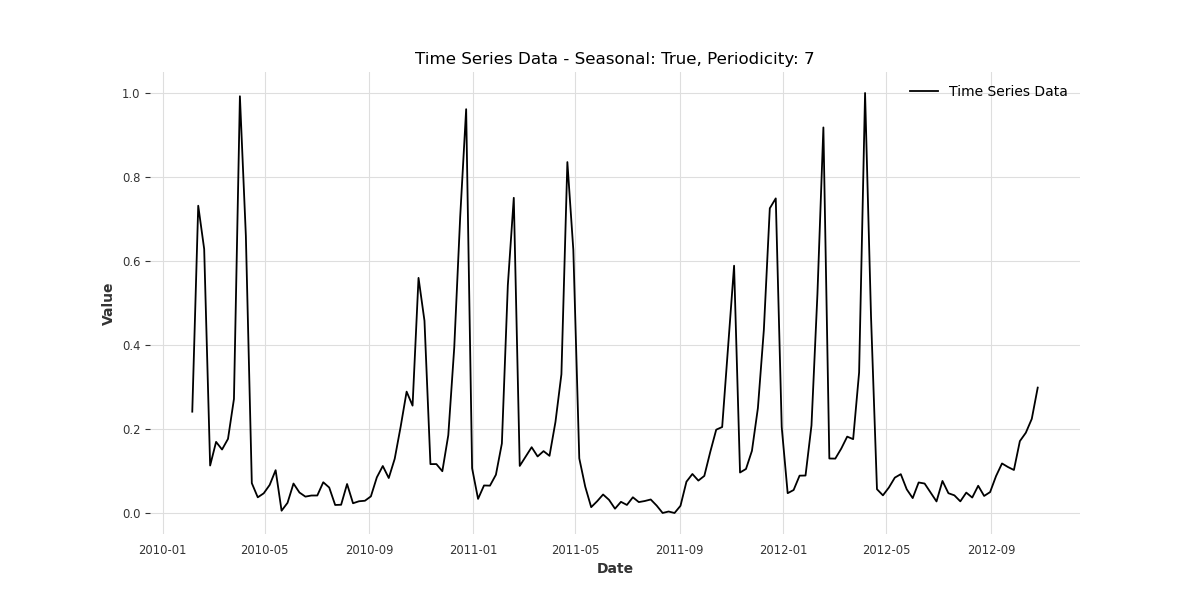

1: Is Seasonal: True, Periodicity: 4


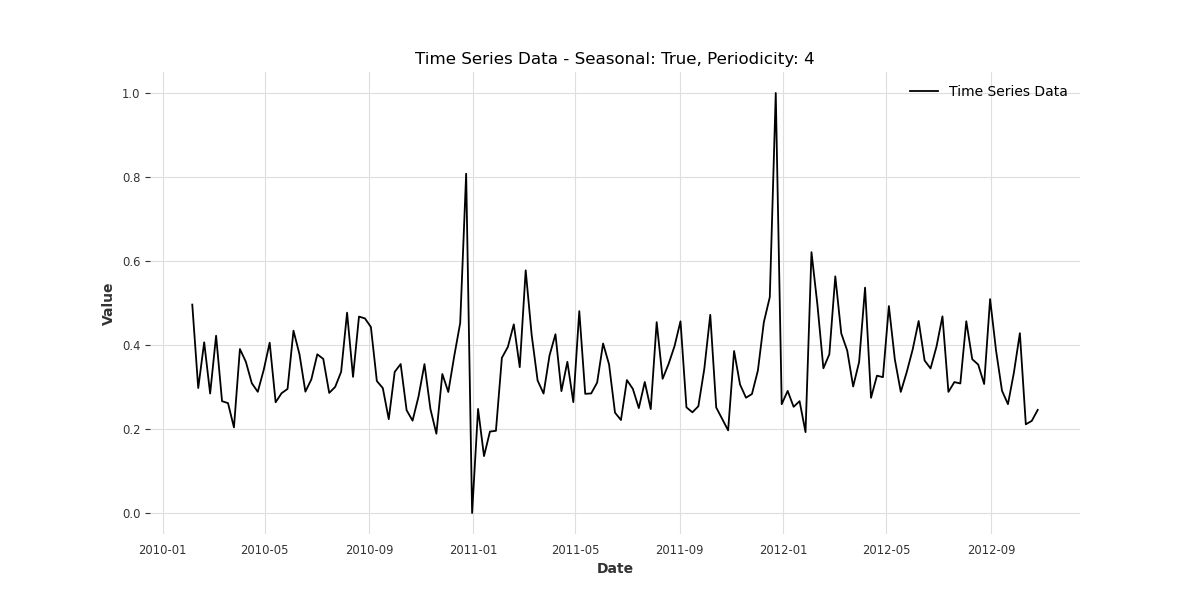

2: Is Seasonal: True, Periodicity: 52


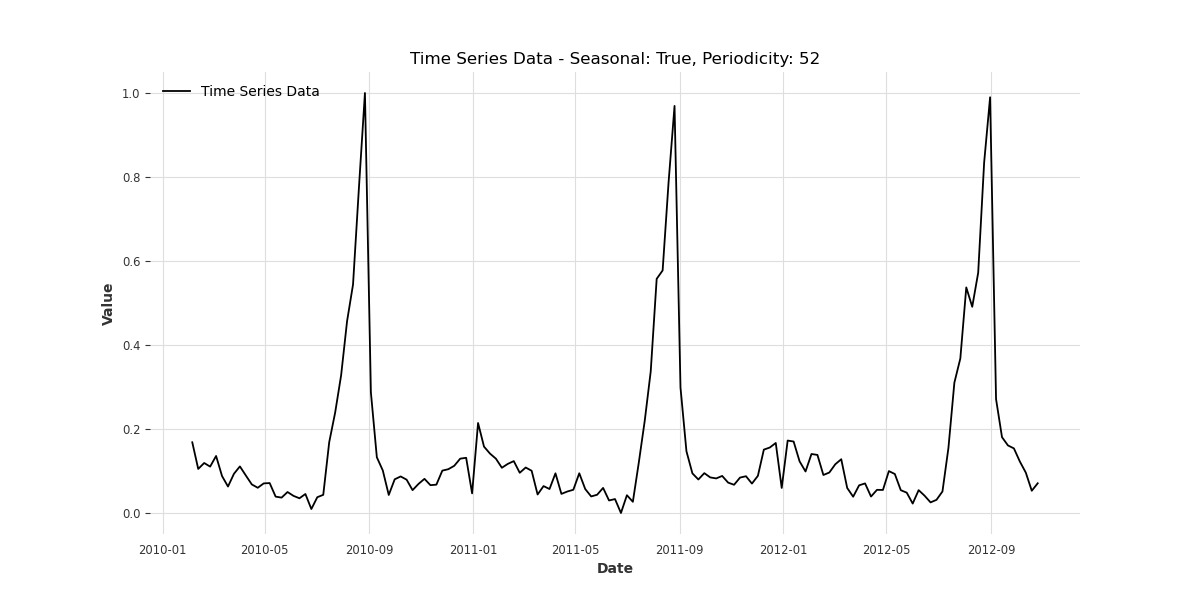

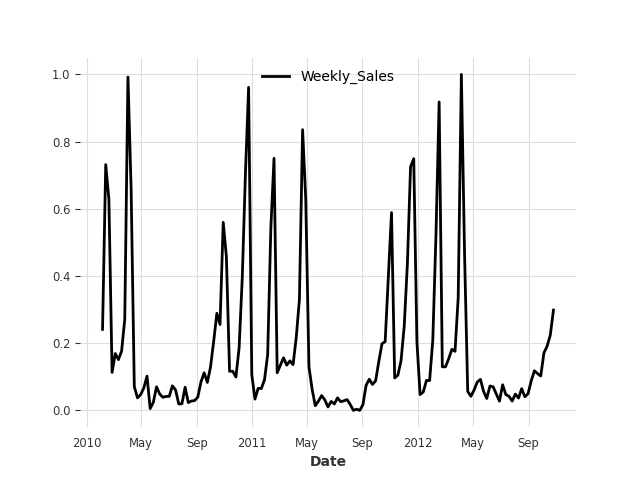

In [8]:
from darts.utils.statistics import check_seasonality
preprocessor = WalmartPreprocessor(train_df, test_df, stores_df, features_df)
preprocessor.target_series[0][0].plot()
for i in range(3):
    is_seasonal, periodicity =check_seasonality(preprocessor.target_series[0][i], max_lag=104)
    print(f"{i}: Is Seasonal: {is_seasonal}, Periodicity: {periodicity}")
    # Plotting the time series 
    plt.figure(figsize=(12, 6)) 
    plt.plot(preprocessor.target_series[0][i].time_index, preprocessor.target_series[0][i].values(), label='Time Series Data') 
    plt.title(f'Time Series Data - Seasonal: {is_seasonal}, Periodicity: {periodicity}') 
    plt.xlabel('Date') 
    plt.ylabel('Value') 
    plt.legend() 
    plt.show()

In [9]:
# class WalmartModel:
#     def __init__(self, 
#                  preprocessor: WalmartPreprocessor, 
#                  input_chunk_length: int = 12,
#                  forecast_horizon: int = 4,
#                  hidden_size: int = 64,
#                  lstm_layers: int = 2,
#                  num_attention_heads: int = 4,
#                  dropout: float = 0.1,
#                  batch_size: int = 32,
#                  n_epochs: int = 1000):
        
#         self.preprocessor = preprocessor
#         self.input_chunk_length = input_chunk_length
#         self.forecast_horizon = forecast_horizon
        
#         # Define quantiles for probabilistic forecasting
#         quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        
#         # Create early stopping callback
#         early_stop_callback = pl.callbacks.EarlyStopping(
#             monitor='val_loss',
#             min_delta=0.001,
#             patience=10,
#             mode='min'
#         )
        
#         # Initialize TFT model with early stopping
#         self.model = TFTModel(
#             input_chunk_length=input_chunk_length,
#             output_chunk_length=forecast_horizon,
#             hidden_size=hidden_size,
#             lstm_layers=lstm_layers,
#             num_attention_heads=num_attention_heads,
#             dropout=dropout,
#             batch_size=batch_size,
#             n_epochs=n_epochs,
#             likelihood=QuantileRegression(quantiles=quantiles),
#             random_state=42,
#             use_static_covariates=True,
#             add_relative_index=True,
#             pl_trainer_kwargs={
#                 "enable_checkpointing": True,
#                 "callbacks": [early_stop_callback],
#                 "gradient_clip_val": 1.0,
#                 "accelerator": "cpu",  # Use CPU for training
#                 "max_epochs": n_epochs
#             }
#         )

#     def train_and_validate(self):
#         # Train the model with validation and create performance plots
#         # Scale the series
#         scaler = Scaler()
#         scaled_series = scaler.fit_transform(self.preprocessor.target_series)
#         scaled_covs = scaler.fit_transform(self.preprocessor.past_cov_series)
        
#         # Train the model
#         self.model.fit(
#             series=scaled_series,
#             past_covariates=scaled_covs,
#             val_series=scaled_series,  # Using same series for validation
#             val_past_covariates=scaled_covs,
#             verbose=True
#         )
        
#         # Create backtest predictions
#         backtest = self.model.historical_forecasts(
#             series=scaled_series,
#             past_covariates=scaled_covs,
#             start=int(len(scaled_series[0]) * 0.8),
#             forecast_horizon=self.forecast_horizon,
#             retrain=False,
#             verbose=True
#         )
        
#         # Plot results for the first store
#         plt.figure(figsize=(15, 6))
#         actual_sales = scaler.inverse_transform(scaled_series[0])
#         forecasted_sales = scaler.inverse_transform(backtest[0])
        
#         actual_sales.plot(label='Actual')
#         forecasted_sales.plot(label='Forecast')
#         plt.title(f'Walmart Store {self.preprocessor.target_series[0].static_covariates["Store"]} Sales Forecast vs Actual')
#         plt.legend()
#         plt.show()
        
#         # Calculate and print metrics
#         mape_score = mape(actual_sales, forecasted_sales)
#         rmse_score = rmse(actual_sales, forecasted_sales)
#         print(f"MAPE: {mape_score:.2f}%")
#         print(f"RMSE: {rmse_score:.2f}")
        
#         return backtest

#     def forecast_future(self, weeks_ahead: int = 4):
#         # Generate forecasts for future weeks
#         # Scale the input data
#         scaler = Scaler()
#         scaled_targets = scaler.fit_transform(self.preprocessor.target_series)
#         scaled_covs = scaler.fit_transform(self.preprocessor.past_cov_series)
        
#         # Generate forecasts
#         scaled_forecasts = self.model.predict(n=weeks_ahead, series=scaled_targets, past_covariates=scaled_covs)
        
#         # Inverse transform the forecasts
#         forecasts = scaler.inverse_transform(scaled_forecasts)
#         return forecasts

In [10]:
# class WalmartModel:
#     def __init__(self, 
#                  preprocessor: WalmartPreprocessor, 
#                  input_chunk_length: int = 12,
#                  forecast_horizon: int = 4,
#                  hidden_size: int = 64,
#                  lstm_layers: int = 2,
#                  num_attention_heads: int = 4,
#                  dropout: float = 0.1,
#                  batch_size: int = 32,
#                  n_epochs: int = 1000):
        
#         self.preprocessor = preprocessor
#         self.input_chunk_length = input_chunk_length
#         self.forecast_horizon = forecast_horizon
        
#         # Define quantiles for probabilistic forecasting
#         quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        
#         # Create early stopping callback
#         early_stop_callback = pl.callbacks.EarlyStopping(
#             monitor='val_loss',
#             min_delta=0.001,
#             patience=10,
#             mode='min'
#         )
        
#         # Create model checkpoint callback
#         checkpoint_callback = pl.callbacks.ModelCheckpoint(
#             monitor='val_loss',
#             mode='min',
#             save_top_k=1,
#             save_last=True,
#         )
        
#         # Initialize TFT model with early stopping and GPU support
#         self.model = TFTModel(
#             input_chunk_length=input_chunk_length,
#             output_chunk_length=forecast_horizon,
#             hidden_size=hidden_size,
#             lstm_layers=lstm_layers,
#             num_attention_heads=num_attention_heads,
#             dropout=dropout,
#             batch_size=batch_size,
#             n_epochs=n_epochs,
#             likelihood=QuantileRegression(quantiles=quantiles),
#             random_state=42,
#             use_static_covariates=True,
#             add_relative_index=True,

#             pl_trainer_kwargs={
#                 "accelerator": "cuda",
#                 "devices": 1,
#                 "callbacks": [early_stop_callback],
#                 "enable_progress_bar": True,
#                 "progress_bar_refresh_rate": 1,
#                 "max_epochs": n_epochs,
#                 "logger": False,
#                 "enable_model_summary": True
#             }
#         )

#     def train_and_validate(self):
#         # Train the model with validation and create performance plots

#         print("\nPreparing data for training...")
#         # Scale the series
#         scaler = Scaler()
#         scaled_series = scaler.fit_transform(self.preprocessor.target_series)
#         scaled_covs = scaler.fit_transform(self.preprocessor.past_cov_series)
        
#         print("Starting model training...")
#         # Train the model
#         self.model.fit(
#             series=scaled_series,
#             past_covariates=scaled_covs,
#             val_series=scaled_series,  # Using same series for validation
#             val_past_covariates=scaled_covs,
#             verbose=True
#         )
        
#         print("Creating backtests...")
#         # Create backtest predictions
#         backtest = self.model.historical_forecasts(
#             series=scaled_series,
#             past_covariates=scaled_covs,
#             start=int(len(scaled_series[0]) * 0.8),
#             forecast_horizon=self.forecast_horizon,
#             retrain=False,
#             verbose=True
#         )
        
#         # Plot results for the first store
#         plt.figure(figsize=(15, 6))
#         actual_sales = scaler.inverse_transform(scaled_series[0])
#         forecasted_sales = scaler.inverse_transform(backtest[0])
        
#         actual_sales.plot(label='Actual')
#         forecasted_sales.plot(label='Forecast')
#         plt.title(f'Walmart Store {self.preprocessor.target_series[0].static_covariates["Store"]} Sales Forecast vs Actual')
#         plt.legend()
#         plt.show()
        
#         # Calculate and print metrics
#         mape_score = mape(actual_sales, forecasted_sales)
#         rmse_score = rmse(actual_sales, forecasted_sales)
#         print(f"MAPE: {mape_score:.2f}%")
#         print(f"RMSE: {rmse_score:.2f}")
        
#         return backtest

#     def forecast_future(self, weeks_ahead: int = 4):
#         # Generate forecasts for future weeks
#         print(f"\nGenerating {weeks_ahead}-week forecast...")
#         # Scale the input data
#         scaler = Scaler()
#         scaled_targets = scaler.fit_transform(self.preprocessor.target_series)
#         scaled_covs = scaler.fit_transform(self.preprocessor.past_cov_series)
        
#         # Generate forecasts
#         scaled_forecasts = self.model.predict(n=weeks_ahead, series=scaled_targets, past_covariates=scaled_covs)
        
#         # Inverse transform the forecasts
#         forecasts = scaler.inverse_transform(scaled_forecasts)
#         return forecasts

# Setup TFT Model

In [ ]:
import datetime
class WalmartModel:
   def __init__(self, 
                preprocessor: WalmartPreprocessor, 
                input_chunk_length: int = 12,
                forecast_horizon: int = 4,
                hidden_size: int = 64,
                lstm_layers: int = 2,
                num_attention_heads: int = 4,
                dropout: float = 0.1,
                batch_size: int = 32,
                n_epochs: int = 100):
       
       self.preprocessor = preprocessor
       self.input_chunk_length = input_chunk_length
       self.forecast_horizon = forecast_horizon
       
       # Define quantiles for probabilistic forecasting
       quantiles = [0.1, 0.5, 0.9]  # Reduced quantiles
       
       # Create early stopping callback with train_loss instead of val_loss
       early_stop_callback = pl.callbacks.EarlyStopping(
           monitor='train_loss',  # Changed from val_loss
           min_delta=0.001,
           patience=5,
           verbose=True,
           mode='min'
       )
        
       progress_bar = TQDMProgressBar(
           refresh_rate=1,
           process_position=0
       )
        
       self.model = TFTModel(
           input_chunk_length=input_chunk_length,
           output_chunk_length=forecast_horizon,
           hidden_size=hidden_size,
           lstm_layers=lstm_layers,
           num_attention_heads=num_attention_heads,
           dropout=dropout,
           batch_size=batch_size,
           n_epochs=n_epochs,
           likelihood=QuantileRegression(quantiles=[0.1, 0.5, 0.9]),
           random_state=42,
           use_static_covariates=True,
           add_relative_index=True,
           pl_trainer_kwargs={
               "accelerator": "cuda",
               "devices": 1,
               "callbacks": [early_stop_callback, progress_bar],
               "enable_progress_bar": True,
               "max_epochs": n_epochs,
               "logger": False,
               "enable_model_summary": True
           }
       )

   def train_and_validate(self):
       try:
           print("\nPreparing data for training...")
           #scaler = Scaler()
           #scaled_series = scaler.fit_transform(self.preprocessor.target_series[0])
           #covs_scaler = Scaler()
           #scaled_covs = covs_scaler.fit_transform(self.preprocessor.past_cov_series[0])
            
           # Train model
           print("\nStarting model training...")
           self.model.fit(
               #series=scaled_series,
               #past_covariates=scaled_covs,
               series = self.preprocessor.target_series[0],
               past_covariates = self.preprocessor.past_cov_series[0],
               verbose=True
           )
           
           # Generate backtests
           print("\nGenerating backtests...")
           #train_cutoff = int(len(scaled_series[0]) * 0.8)
           train_cutoff = int(len(self.preprocessor.target_series[0]) * 0.8)
           backtest = self.model.historical_forecasts(
               #series=scaled_series,
               #past_covariates=scaled_covs,
               series = self.preprocessor.target_series[0],
               past_covariates = self.preprocessor.past_cov_series[0],
               start=train_cutoff,
               forecast_horizon=self.forecast_horizon,
               retrain=False,
               verbose=True
           )
           
           # Plot results
           self._plot_results(self.preprocessor.target_series[0], backtest, self.preprocessor.value_scaler)
           
           # Calculate metrics
           print("\nCalculating actual metrics...")
           #actual = scaler.inverse_transform(scaled_series)
           actual = self.preprocessor.value_scaler.inverse_transform(self.preprocessor.target_series[0])
           print("\nCalculating pred metrics...")
           #pred = scaler.inverse_transform(backtest)
           pred = self.preprocessor.value_scaler.inverse_transform(backtest)
           static_vals = self.preprocessor.static_transformer.inverse_transform(self.preprocessor.target_series[0])
           mape_score = mape(actual, pred)
           rmse_score = rmse(actual, pred)
           
           for i in range(len(mape_score)):
               print(f"\nMetrics for Store {static_vals[i].static_covariates['Store']['Weekly_Sales']} Dept {static_vals[i].static_covariates['Dept']['Weekly_Sales']}:")
               print(f"MAPE_{i}: {mape_score[i]:.2f}%")
               print(f"RMSE_{i}: ${rmse_score[i]:.2f}")
           
           return backtest
           
       except Exception as e:
           print(f"Error during training: {str(e)}")
           raise

   def _plot_results2(self, actual_scaled, pred_scaled, scaler):
       plt.figure(figsize=(15, 6))
       actual = scaler.inverse_transform(actual_scaled)
       pred = scaler.inverse_transform(pred_scaled)
       
       actual[0].plot(label=f'Actual_{datetime.datetime.now()}')
       pred[0].plot(label='Forecast')
       plt.title(f"Store {self.preprocessor.target_series[0][0].static_covariates['Store']['Weekly_Sales']} Dept {self.preprocessor.target_series[0][0].static_covariates['Dept']['Weekly_Sales']} Sales Forecast")
       plt.legend()
       plt.show()

   def _plot_results(self, actual_scaled, pred_scaled, scaler):
       fig, axs = plt.subplots(9, figsize=(15, 25), sharex=True)

       actual = scaler.inverse_transform(actual_scaled)
       pred = scaler.inverse_transform(pred_scaled)
       static_vals = self.preprocessor.static_transformer.inverse_transform(actual_scaled)
       
       for i in range(9):
           store = int(static_vals[i].static_covariates['Store']['Weekly_Sales'])
           dept = int(static_vals[i].static_covariates['Dept']['Weekly_Sales'])
           actual[i].plot(label=f'Actual', ax=axs[i])
           pred[i].plot(label=f'Forecast', ax=axs[i])
           axs[i].set_title(f'Store {store} Dept {dept} Sales Forecast')
           axs[i].tick_params(labelbottom=True)
            
       plt.tight_layout()
       plt.legend()
       plt.show()

   def forecast_future(self, weeks_ahead: int = 4):
       try:
           print(f"\nGenerating {weeks_ahead}-week forecast...")
           
           scaled_forecasts = self.model.predict(
               n=weeks_ahead, 
               series = self.preprocessor.target_series[0],
               past_covariates = self.preprocessor.past_cov_series[0],
           )
           
           return self.preprocessor.value_scaler.inverse_transform(scaled_forecasts)
           
       except Exception as e:
           print(f"Error during forecasting: {str(e)}")
           raise

# Config models and execute

Starting preprocessing...
Train shape: (421570, 5)
Test shape: (115064, 4)
Stores shape: (45, 3)
Features shape: (8190, 12)
Filtering data...
Train shape after filtering: (1287, 5)
Test shape after filtering: (351, 4)
Stores shape after filtering: (3, 3)
Features shape after filtering: (546, 12)
Converting dates...
Pimping store data...
Store static columns: ['Size', 'Type_A', 'Type_B']
Merging store information...
Training merged shape: (1287, 8)
Testing merged shape: (351, 7)
Converting boolean columns...
Adding features...
Final training shape: (1287, 17)
Creating time series...

Transforming time series...
Scaling target series...
Transformation complete.
Preprocessing complete.

Training model with configuration: {'input_chunk_length': 12, 'lstm_layers': 2}

Preparing data for training...

Starting model training...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 8.5 K  | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 12.5 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont

Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.183
Metric train_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.150
Metric train_loss improved by 0.040 >= min_delta = 0.001. New best score: 0.110
Metric train_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.101
Metric train_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.086
Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.084
Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.082
Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.077
Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.075
Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.069
Metric train_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.053
Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.049
Metric train_loss improved by 0.002 >= min_delta = 0.001. New best sco


Generating backtests...


Predicting: |          | 0/? [00:00<?, ?it/s]

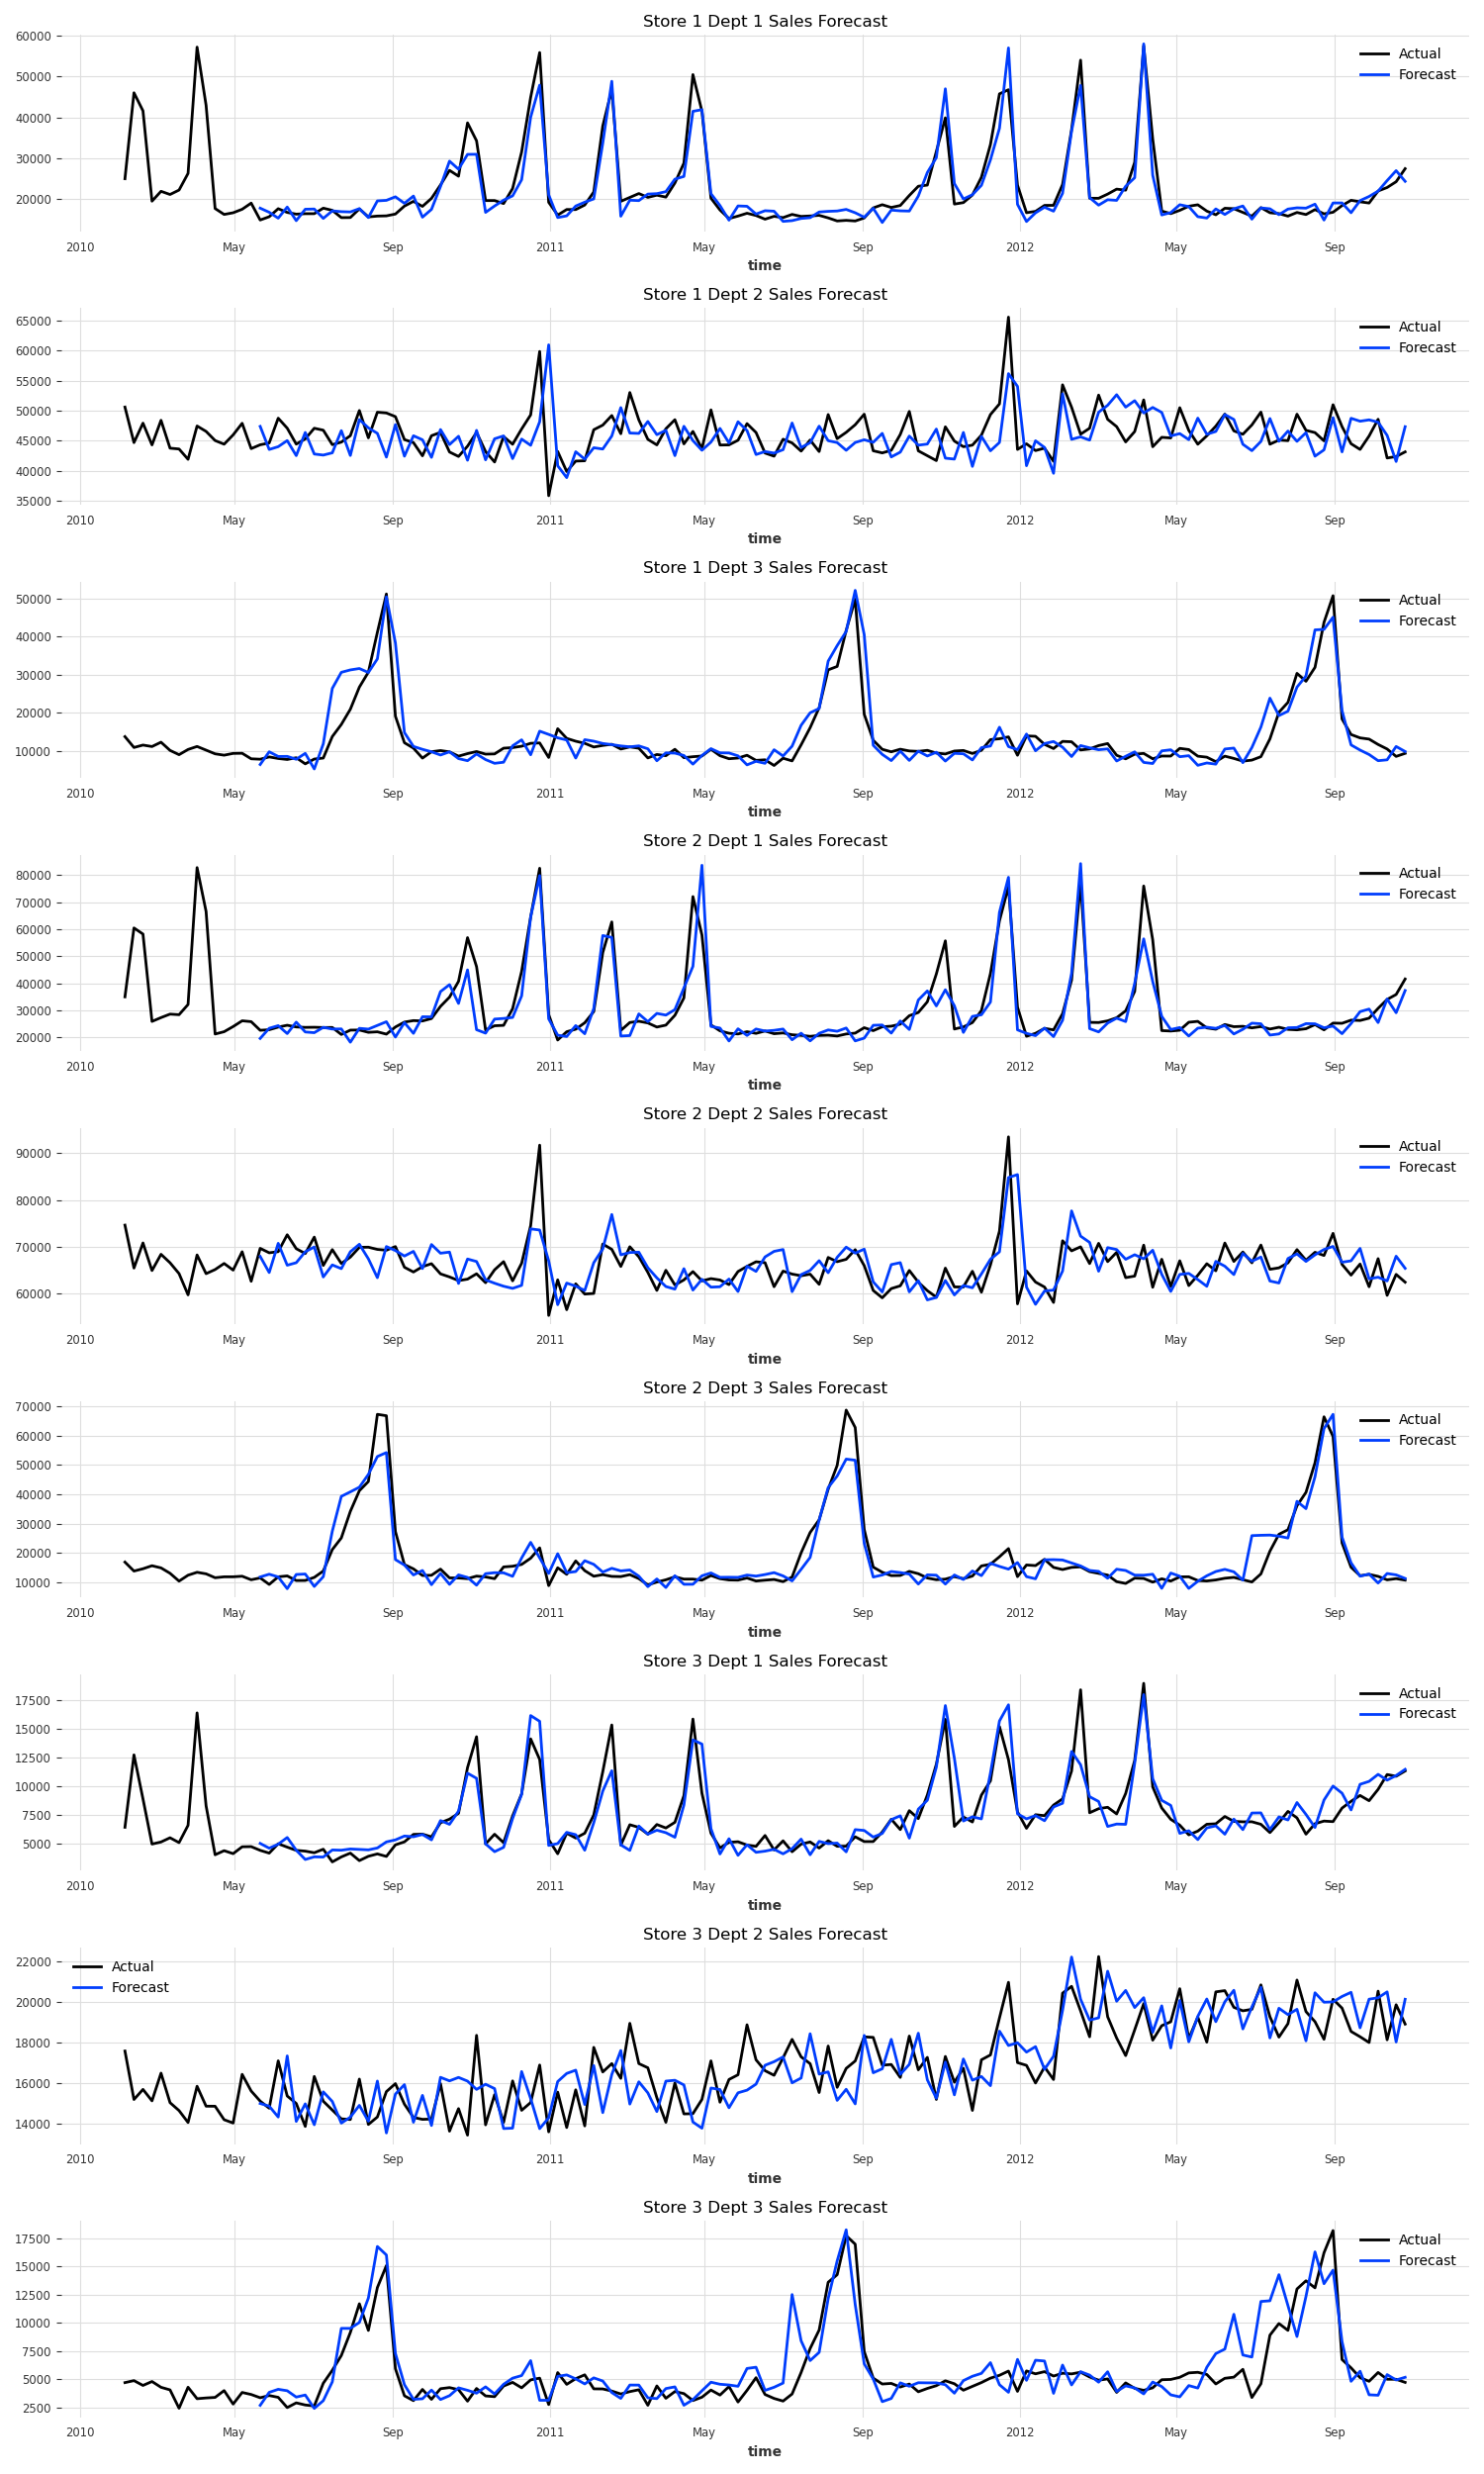

GPU available: True (cuda), used: True



Calculating actual metrics...

Calculating pred metrics...

Metrics for Store 1.0 Dept 1.0:
MAPE_0: 9.05%
RMSE_0: $2913.92

Metrics for Store 1.0 Dept 2.0:
MAPE_1: 6.59%
RMSE_1: $4183.08

Metrics for Store 1.0 Dept 3.0:
MAPE_2: 19.96%
RMSE_2: $4117.91

Metrics for Store 2.0 Dept 1.0:
MAPE_3: 10.58%
RMSE_3: $5860.23

Metrics for Store 2.0 Dept 2.0:
MAPE_4: 4.80%
RMSE_4: $4577.71

Metrics for Store 2.0 Dept 3.0:
MAPE_5: 17.76%
RMSE_5: $4405.31

Metrics for Store 3.0 Dept 1.0:
MAPE_6: 12.47%
RMSE_6: $1446.10

Metrics for Store 3.0 Dept 2.0:
MAPE_7: 6.85%
RMSE_7: $1437.17

Metrics for Store 3.0 Dept 3.0:
MAPE_8: 23.75%
RMSE_8: $1855.95

Generating 4-week forecast...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

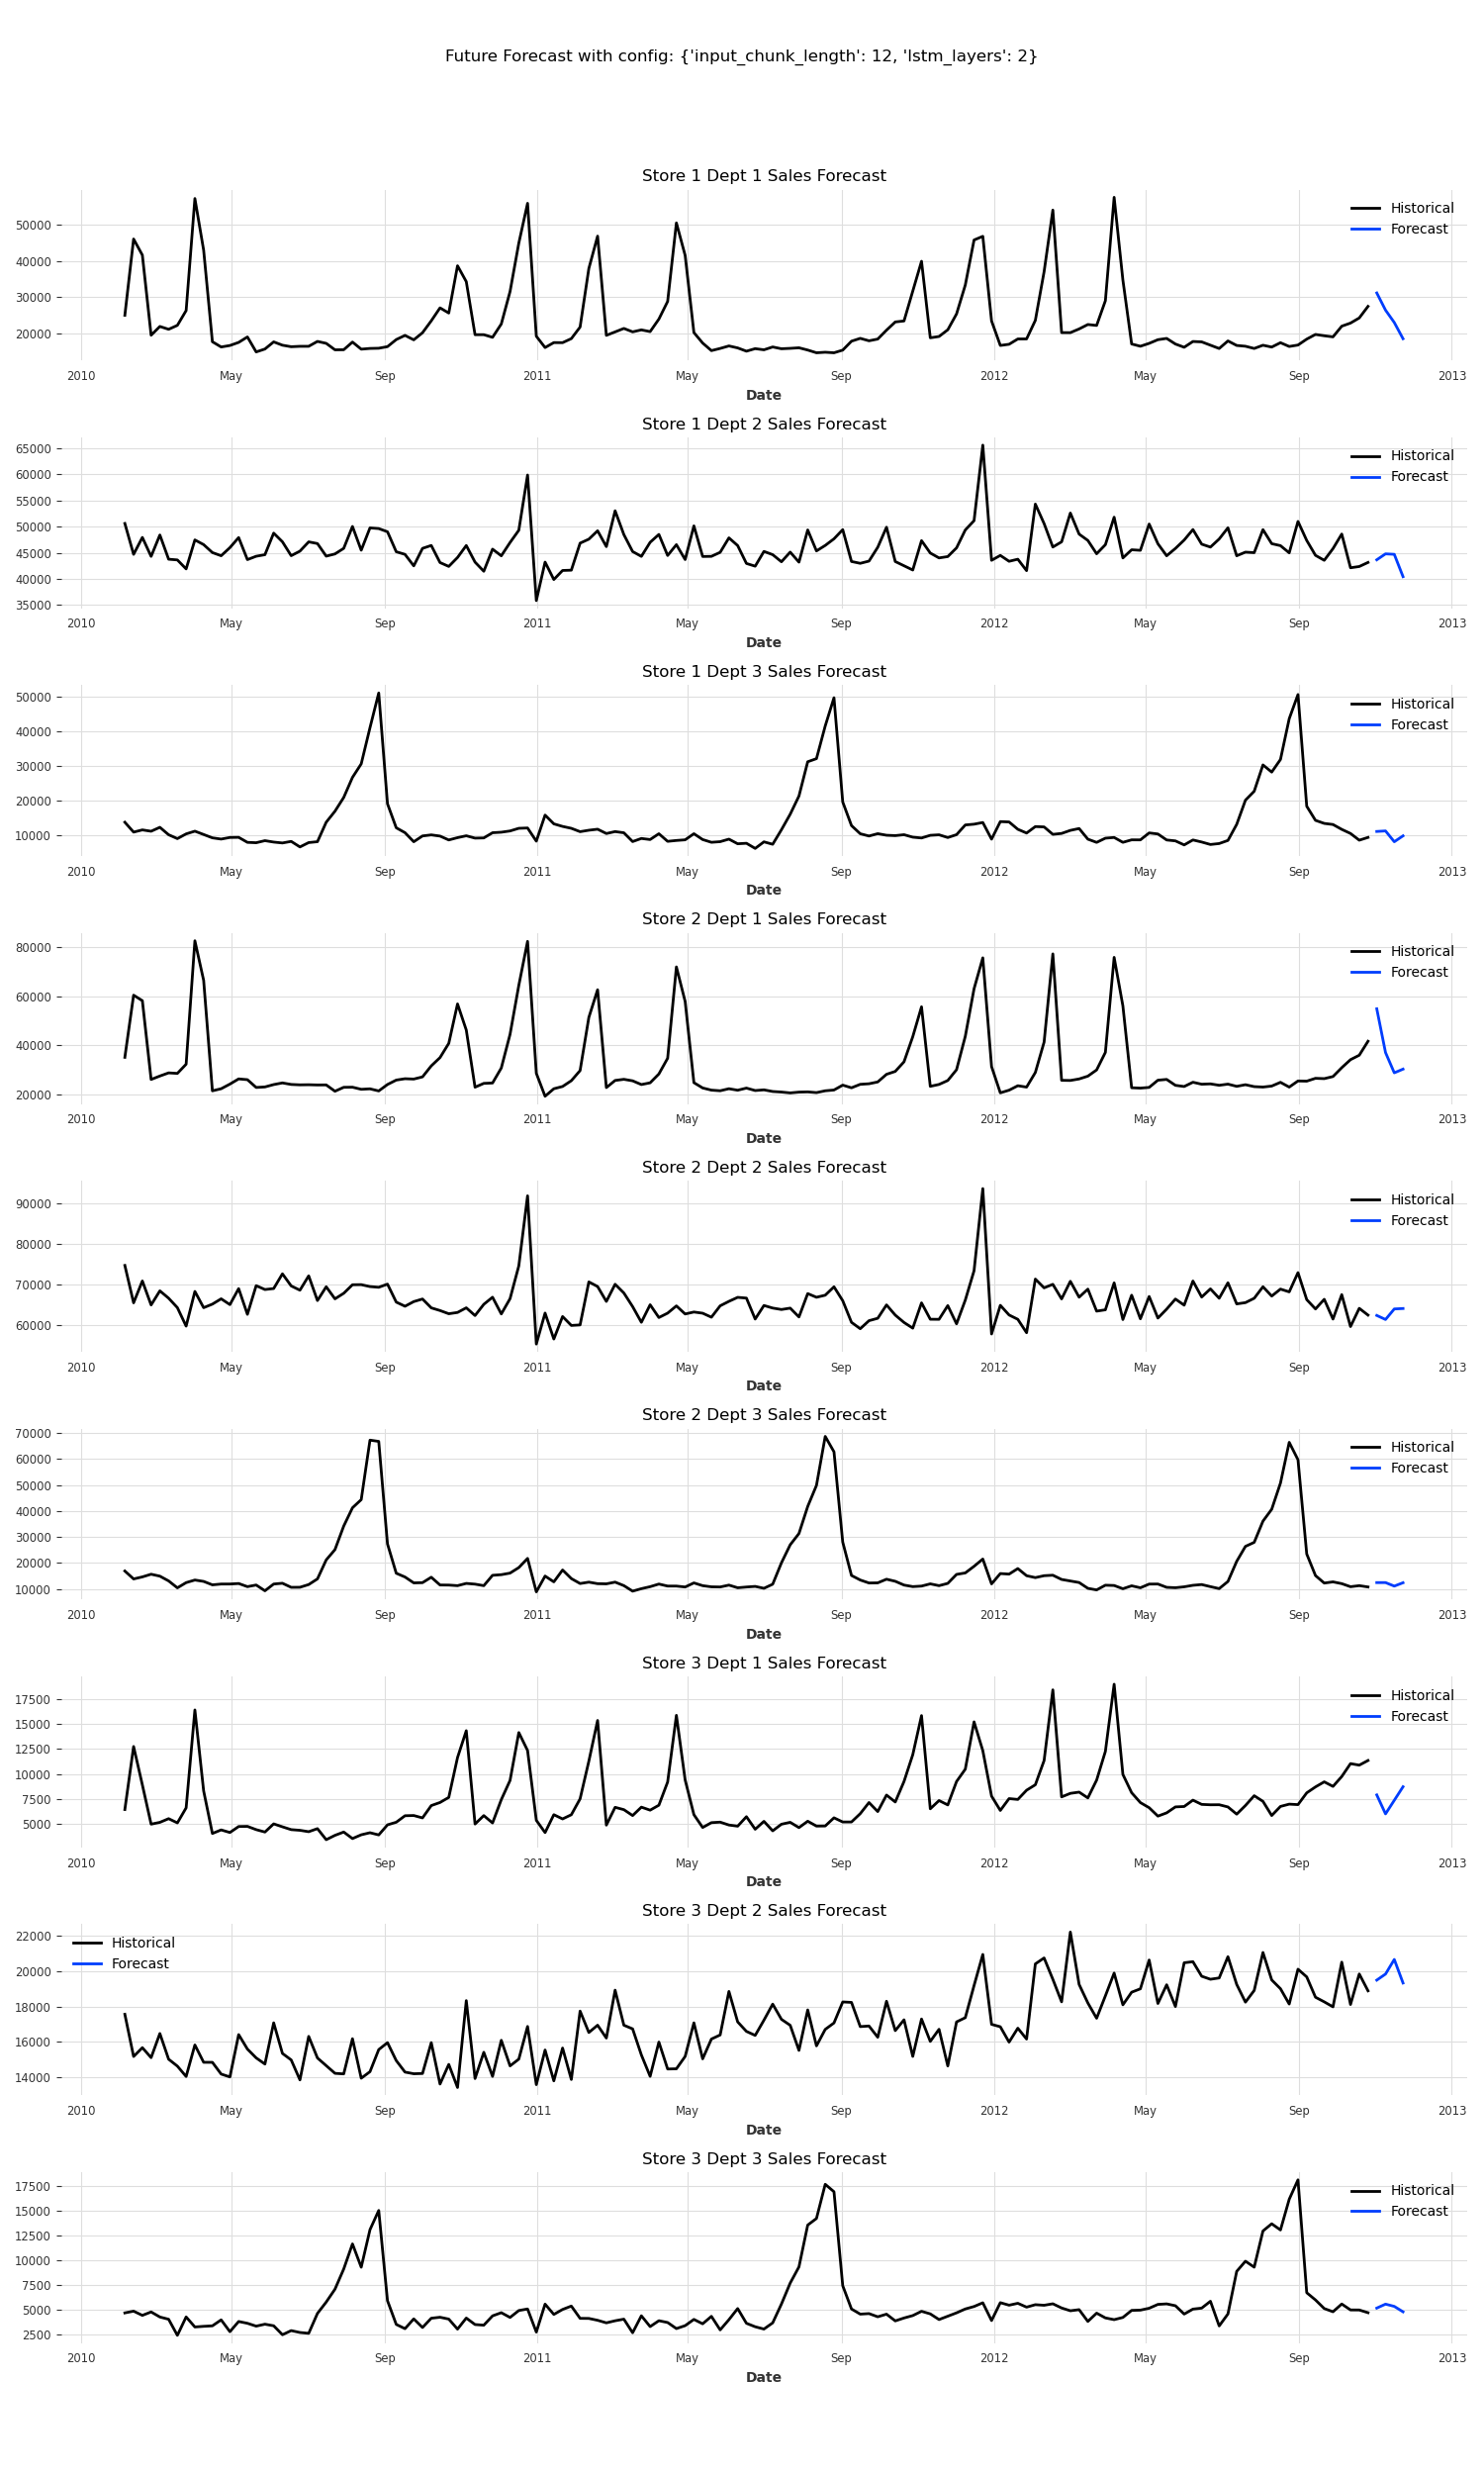

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 8.5 K  | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 12.5 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont


Training model with configuration: {'input_chunk_length': 24, 'lstm_layers': 2}

Preparing data for training...

Starting model training...


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.167
Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.162
Metric train_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.142
Metric train_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.130
Metric train_loss improved by 0.036 >= min_delta = 0.001. New best score: 0.094
Monitored metric train_loss did not improve in the last 5 records. Best score: 0.094. Signaling Trainer to stop.
`start` value `7` corresponding to timestamp `2010-03-26 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2010-07-23 00:00:00. To hide these warnings, set `show_warnings=False`.
`start` value `7` corresponding to timestamp `2010-03-26 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 1. Ignoring `start` for this series and 


Generating backtests...


Predicting: |          | 0/? [00:00<?, ?it/s]

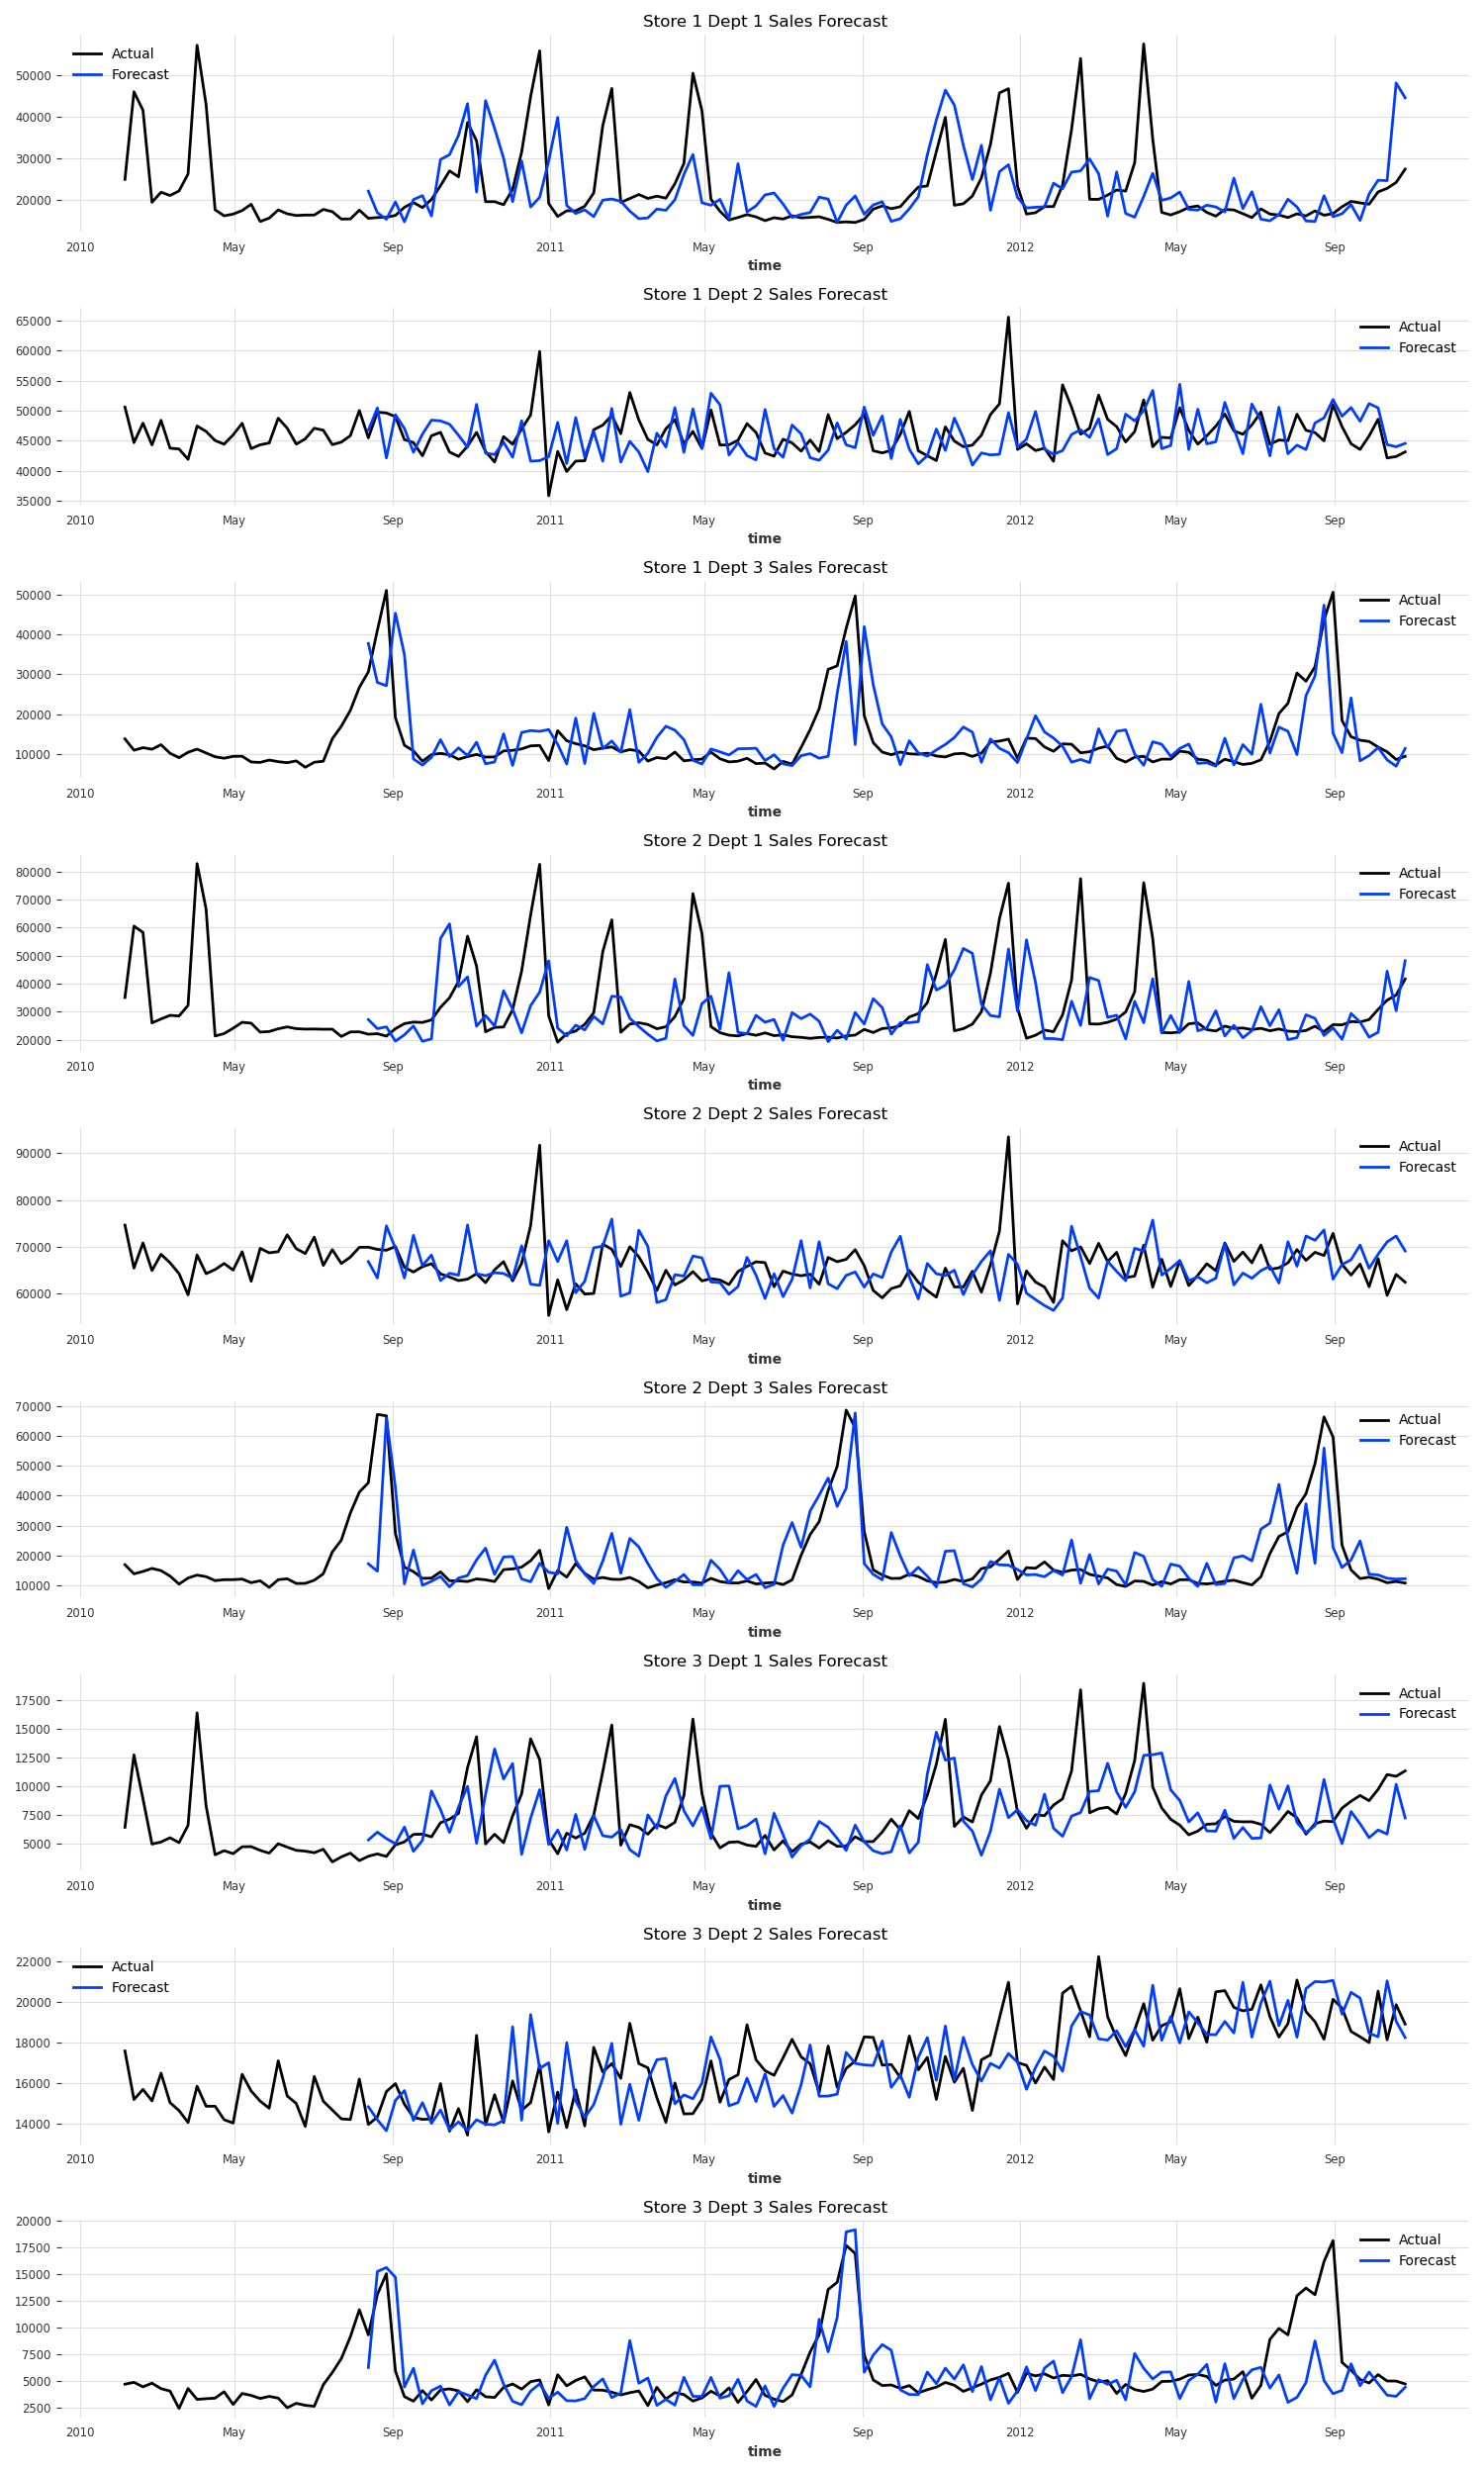

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Calculating actual metrics...

Calculating pred metrics...

Metrics for Store 1.0 Dept 1.0:
MAPE_0: 26.87%
RMSE_0: $10313.65

Metrics for Store 1.0 Dept 2.0:
MAPE_1: 7.32%
RMSE_1: $4507.07

Metrics for Store 1.0 Dept 3.0:
MAPE_2: 36.48%
RMSE_2: $8466.45

Metrics for Store 2.0 Dept 1.0:
MAPE_3: 28.80%
RMSE_3: $14898.66

Metrics for Store 2.0 Dept 2.0:
MAPE_4: 7.25%
RMSE_4: $6710.80

Metrics for Store 2.0 Dept 3.0:
MAPE_5: 36.72%
RMSE_5: $10244.85

Metrics for Store 3.0 Dept 1.0:
MAPE_6: 31.29%
RMSE_6: $3298.93

Metrics for Store 3.0 Dept 2.0:
MAPE_7: 7.96%
RMSE_7: $1750.51

Metrics for Store 3.0 Dept 3.0:
MAPE_8: 31.95%
RMSE_8: $2942.02

Generating 4-week forecast...


Predicting: |          | 0/? [00:00<?, ?it/s]

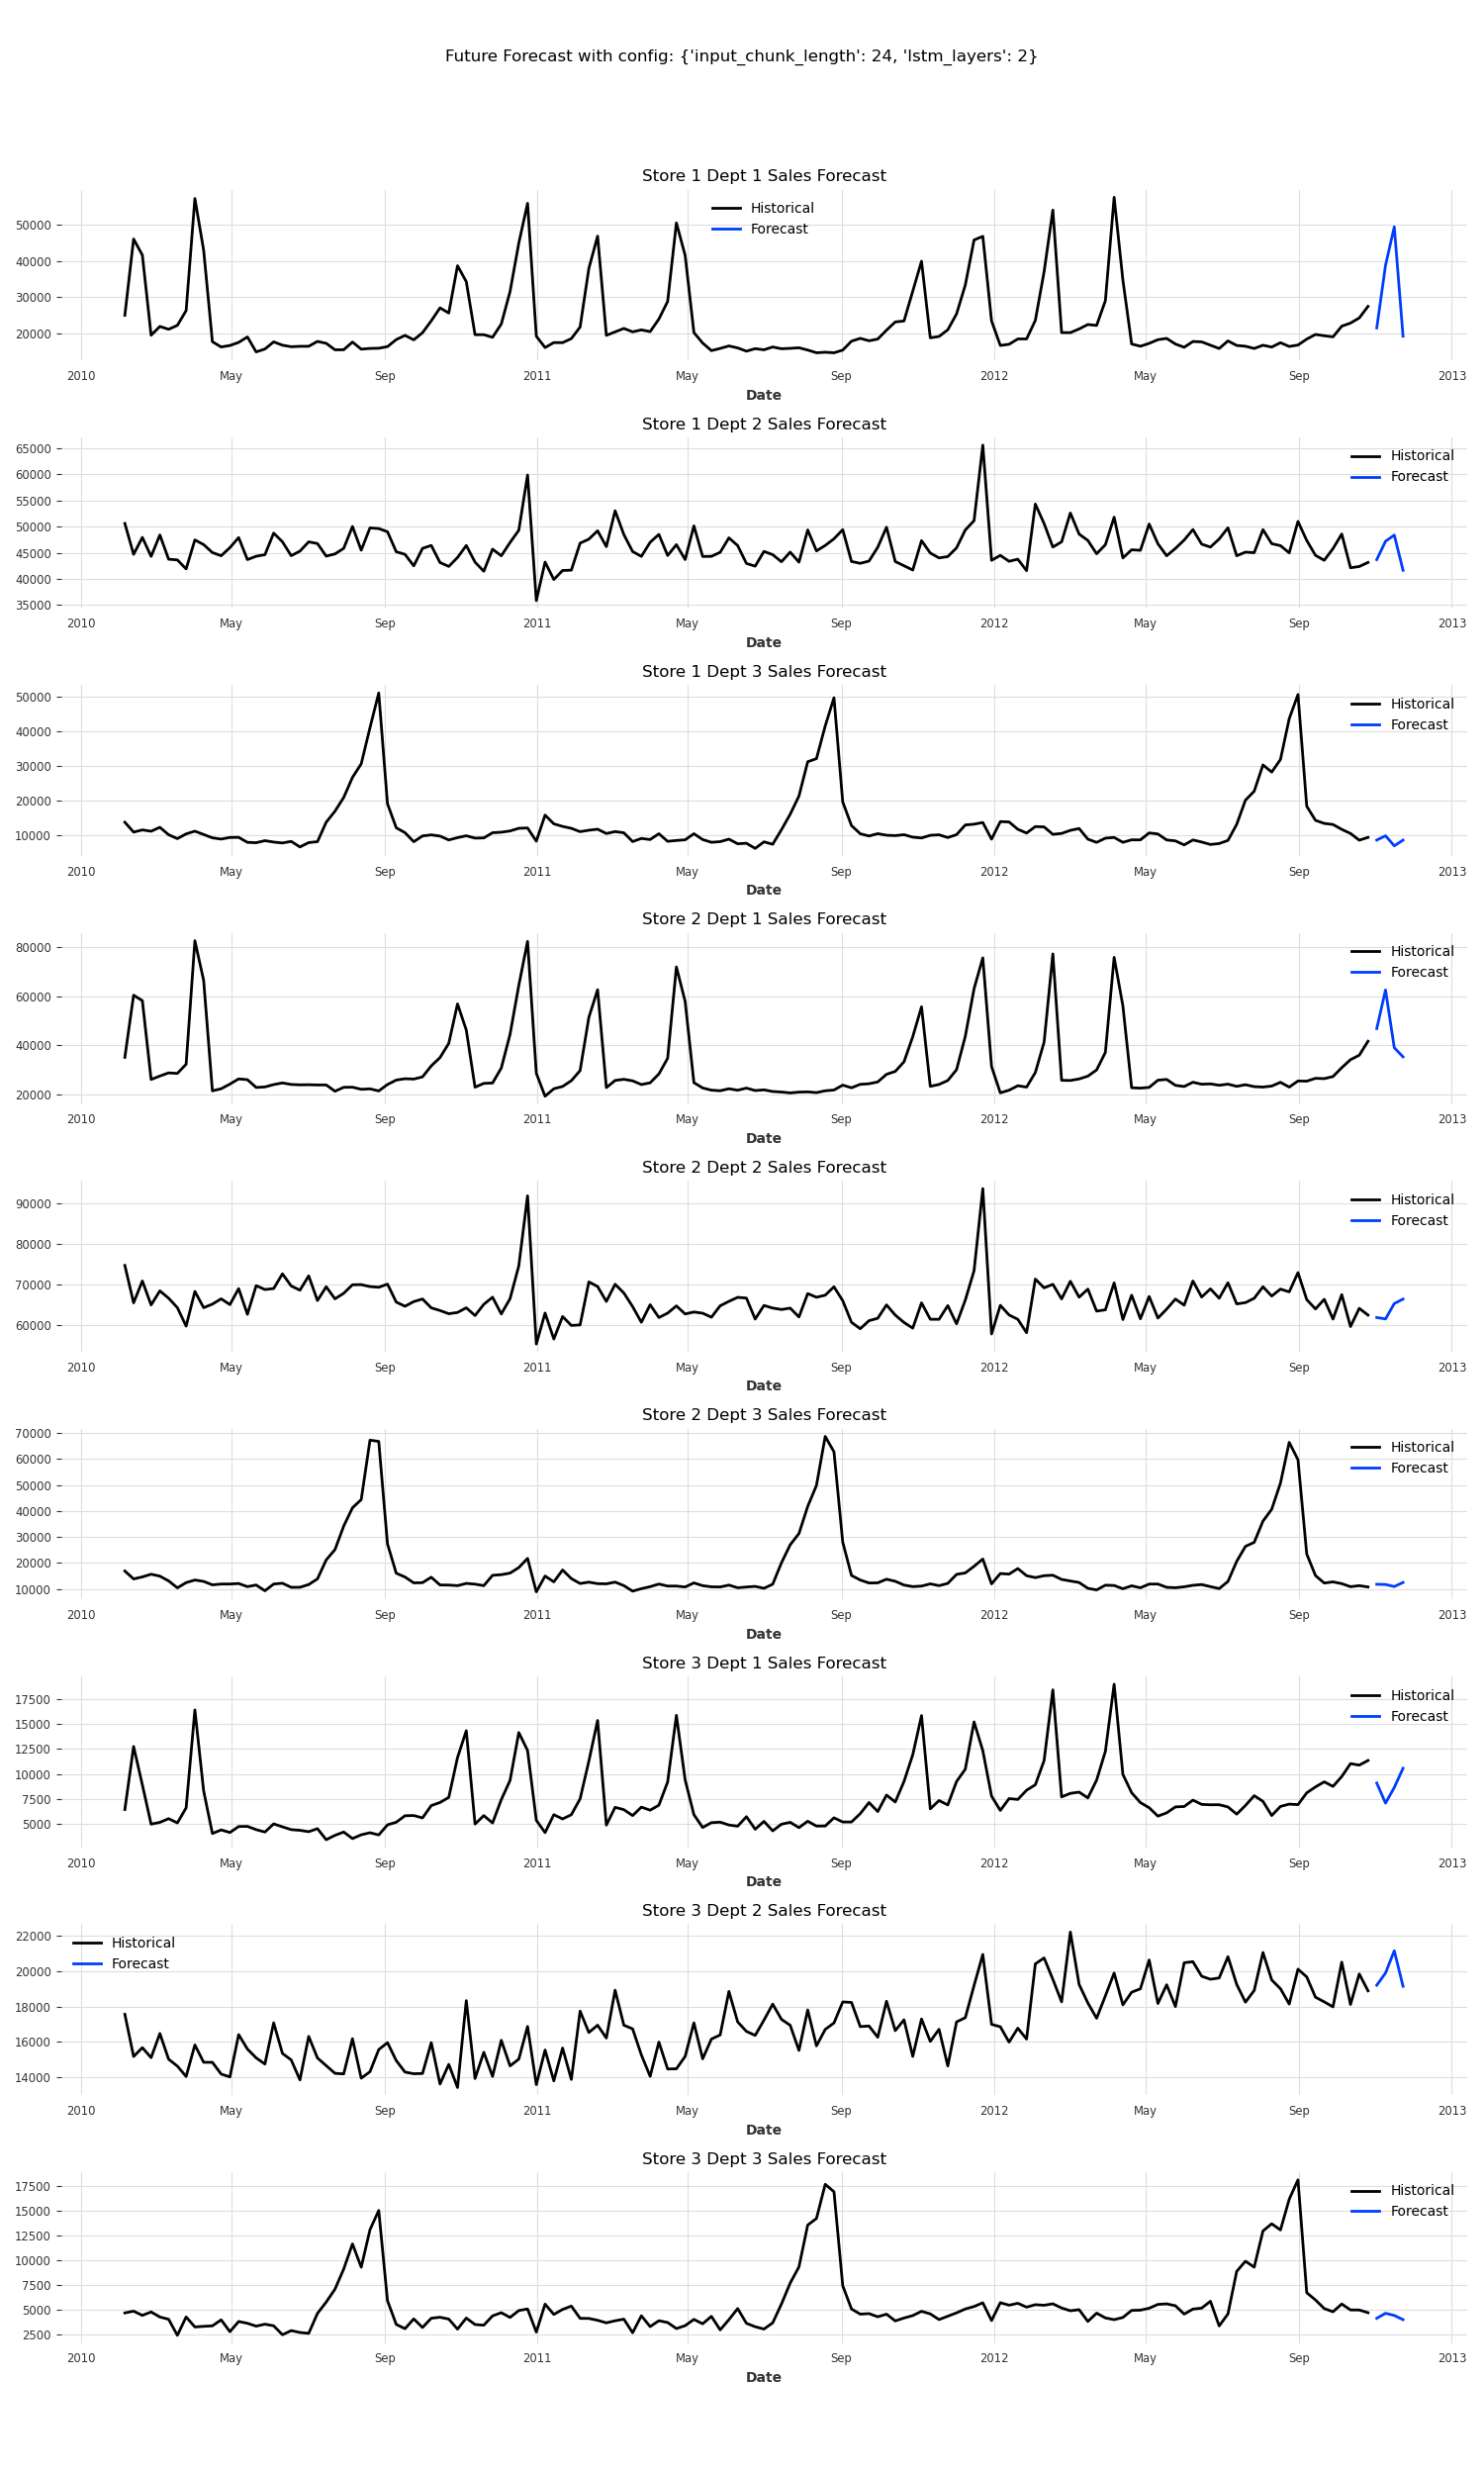

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 8.5 K  | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 12.5 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_cont


Training model with configuration: {'input_chunk_length': 12, 'lstm_layers': 3}

Preparing data for training...

Starting model training...


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.173
Metric train_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.155
Metric train_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.143
Metric train_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.122
Monitored metric train_loss did not improve in the last 5 records. Best score: 0.122. Signaling Trainer to stop.
`start` value `7` corresponding to timestamp `2010-03-26 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2010-04-30 00:00:00. To hide these warnings, set `show_warnings=False`.
`start` value `7` corresponding to timestamp `2010-03-26 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 1. Ignoring `start` for this series and beginning at first trainable/predictable time: 2010-04-30 00:00:00. To hide thes


Generating backtests...


Predicting: |          | 0/? [00:00<?, ?it/s]

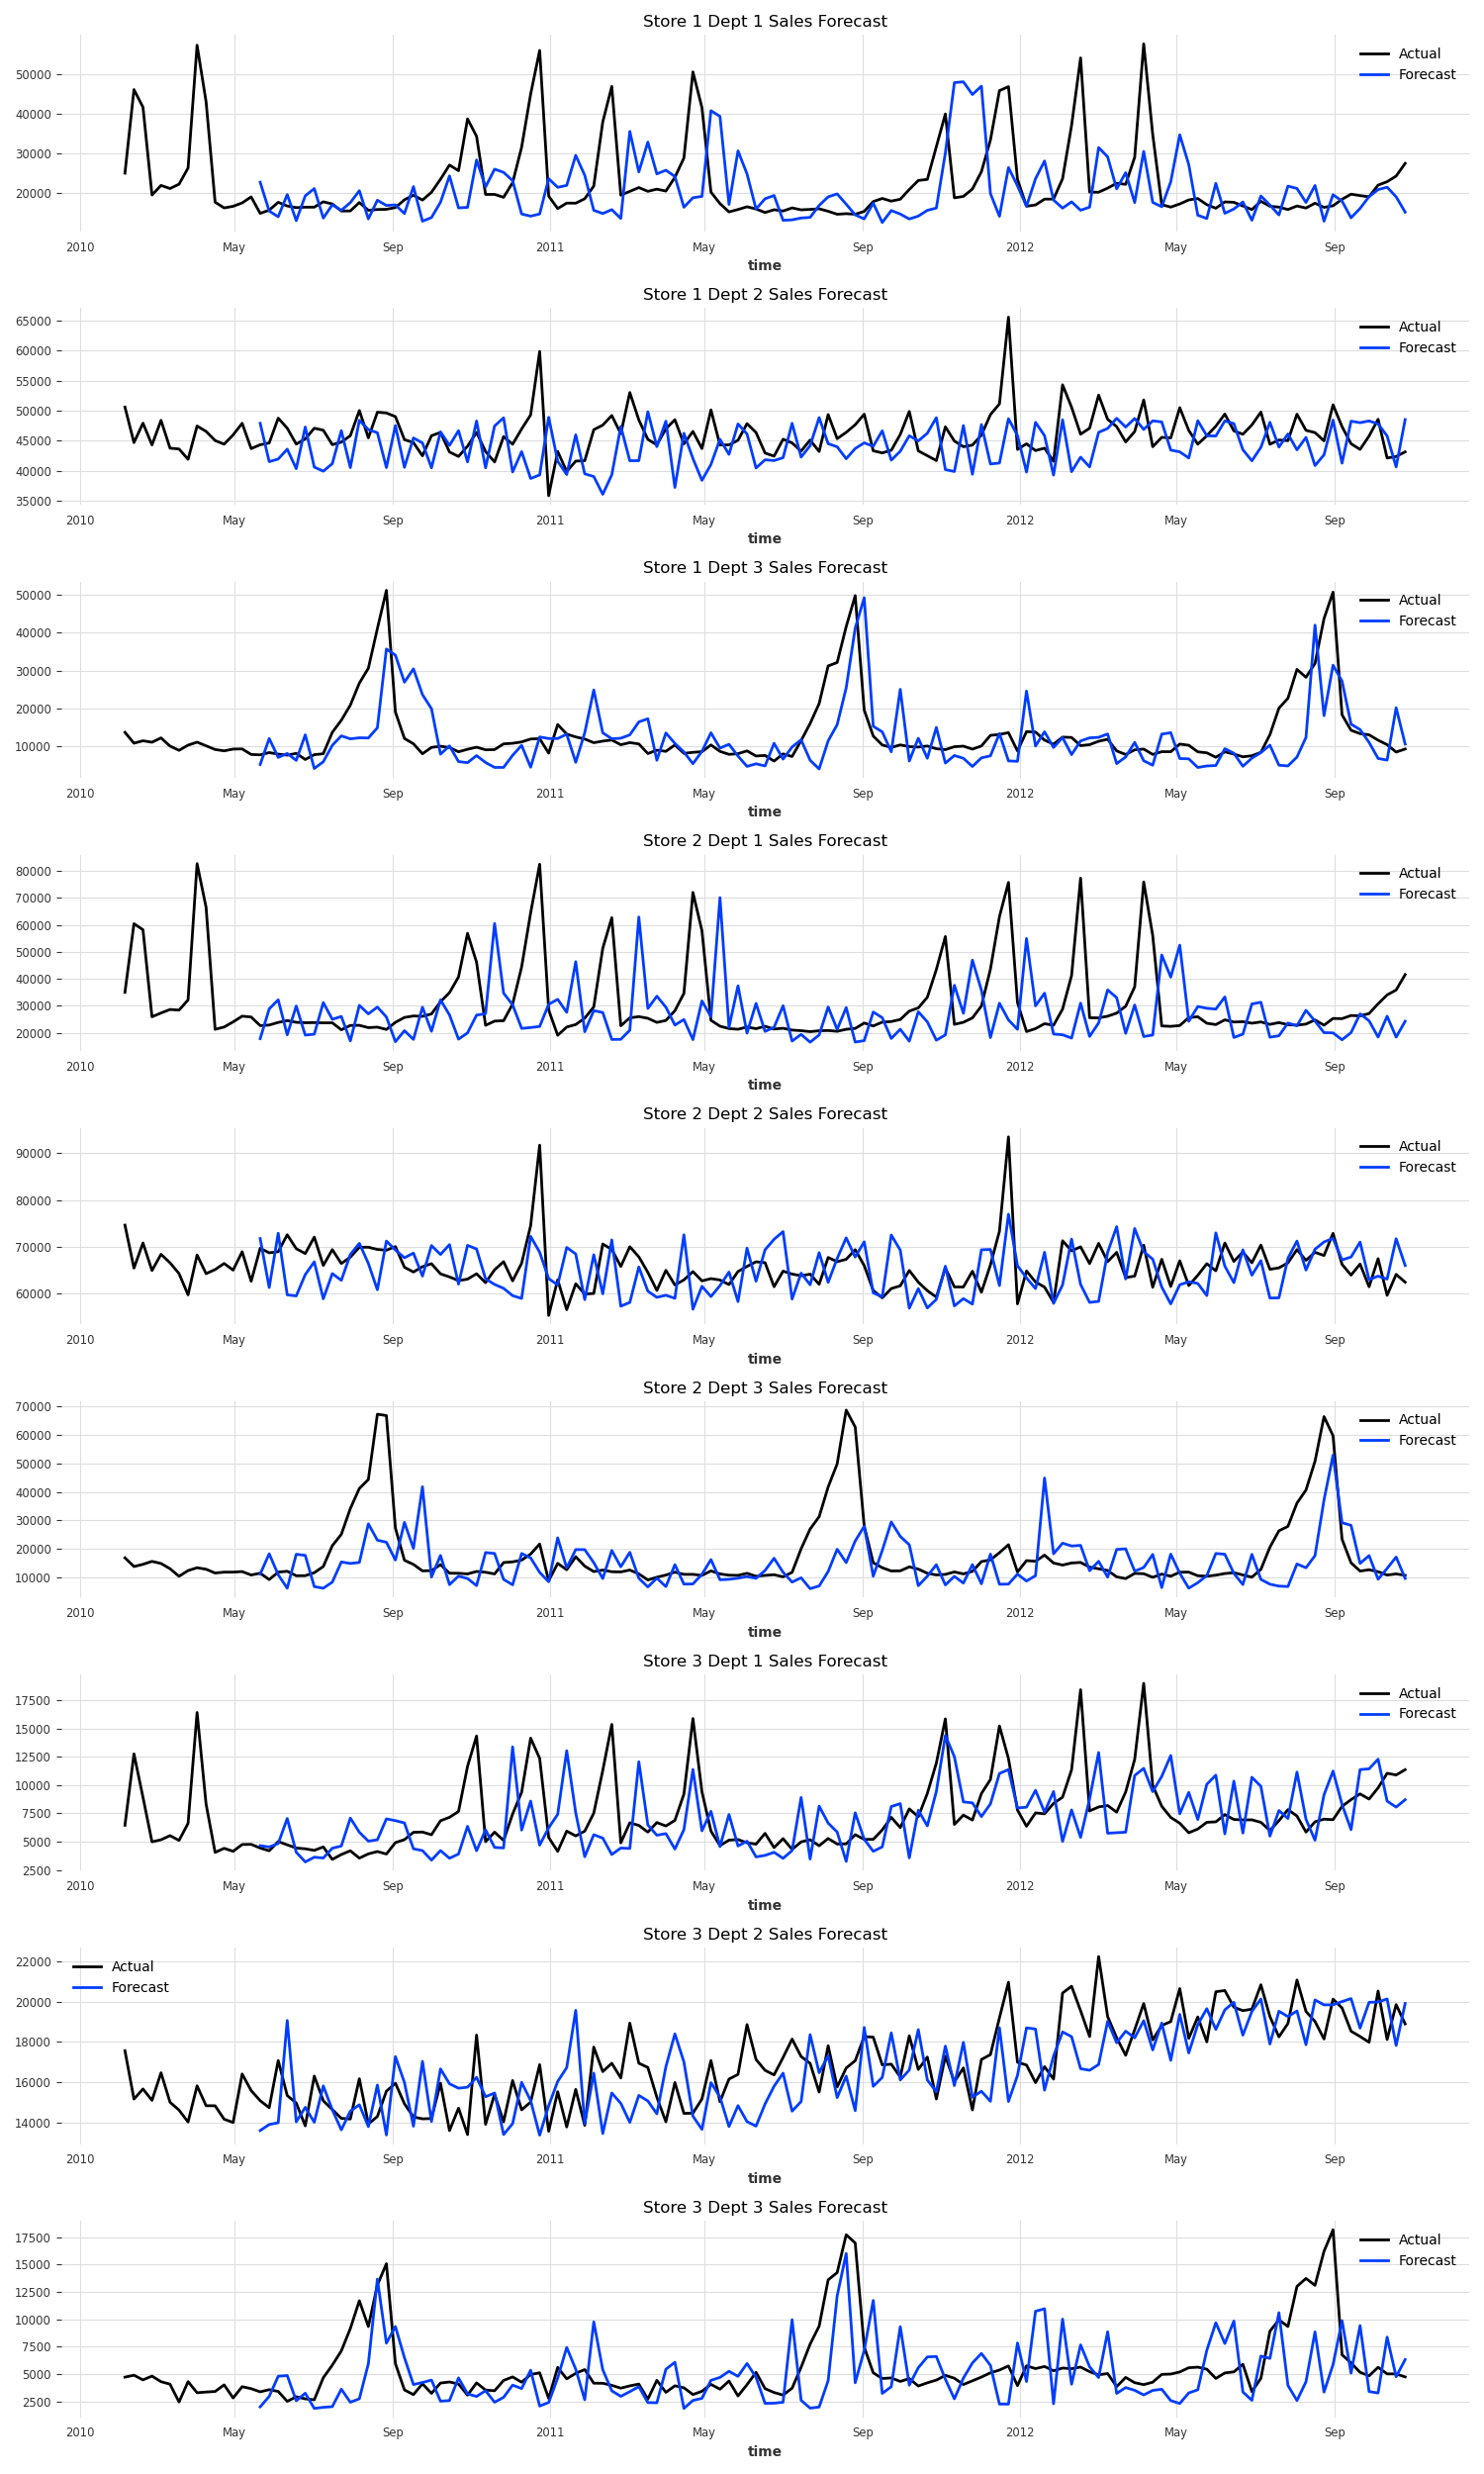

GPU available: True (cuda), used: True



Calculating actual metrics...

Calculating pred metrics...

Metrics for Store 1.0 Dept 1.0:
MAPE_0: 32.29%
RMSE_0: $11984.34

Metrics for Store 1.0 Dept 2.0:
MAPE_1: 8.87%
RMSE_1: $5324.47

Metrics for Store 1.0 Dept 3.0:
MAPE_2: 40.24%
RMSE_2: $8509.61

Metrics for Store 2.0 Dept 1.0:
MAPE_3: 36.31%
RMSE_3: $18095.36

Metrics for Store 2.0 Dept 2.0:
MAPE_4: 7.20%
RMSE_4: $6085.79

Metrics for Store 2.0 Dept 3.0:
MAPE_5: 42.46%
RMSE_5: $13140.23

Metrics for Store 3.0 Dept 1.0:
MAPE_6: 32.30%
RMSE_6: $3269.75

Metrics for Store 3.0 Dept 2.0:
MAPE_7: 8.46%
RMSE_7: $1832.01

Metrics for Store 3.0 Dept 3.0:
MAPE_8: 42.01%
RMSE_8: $3651.05

Generating 4-week forecast...


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

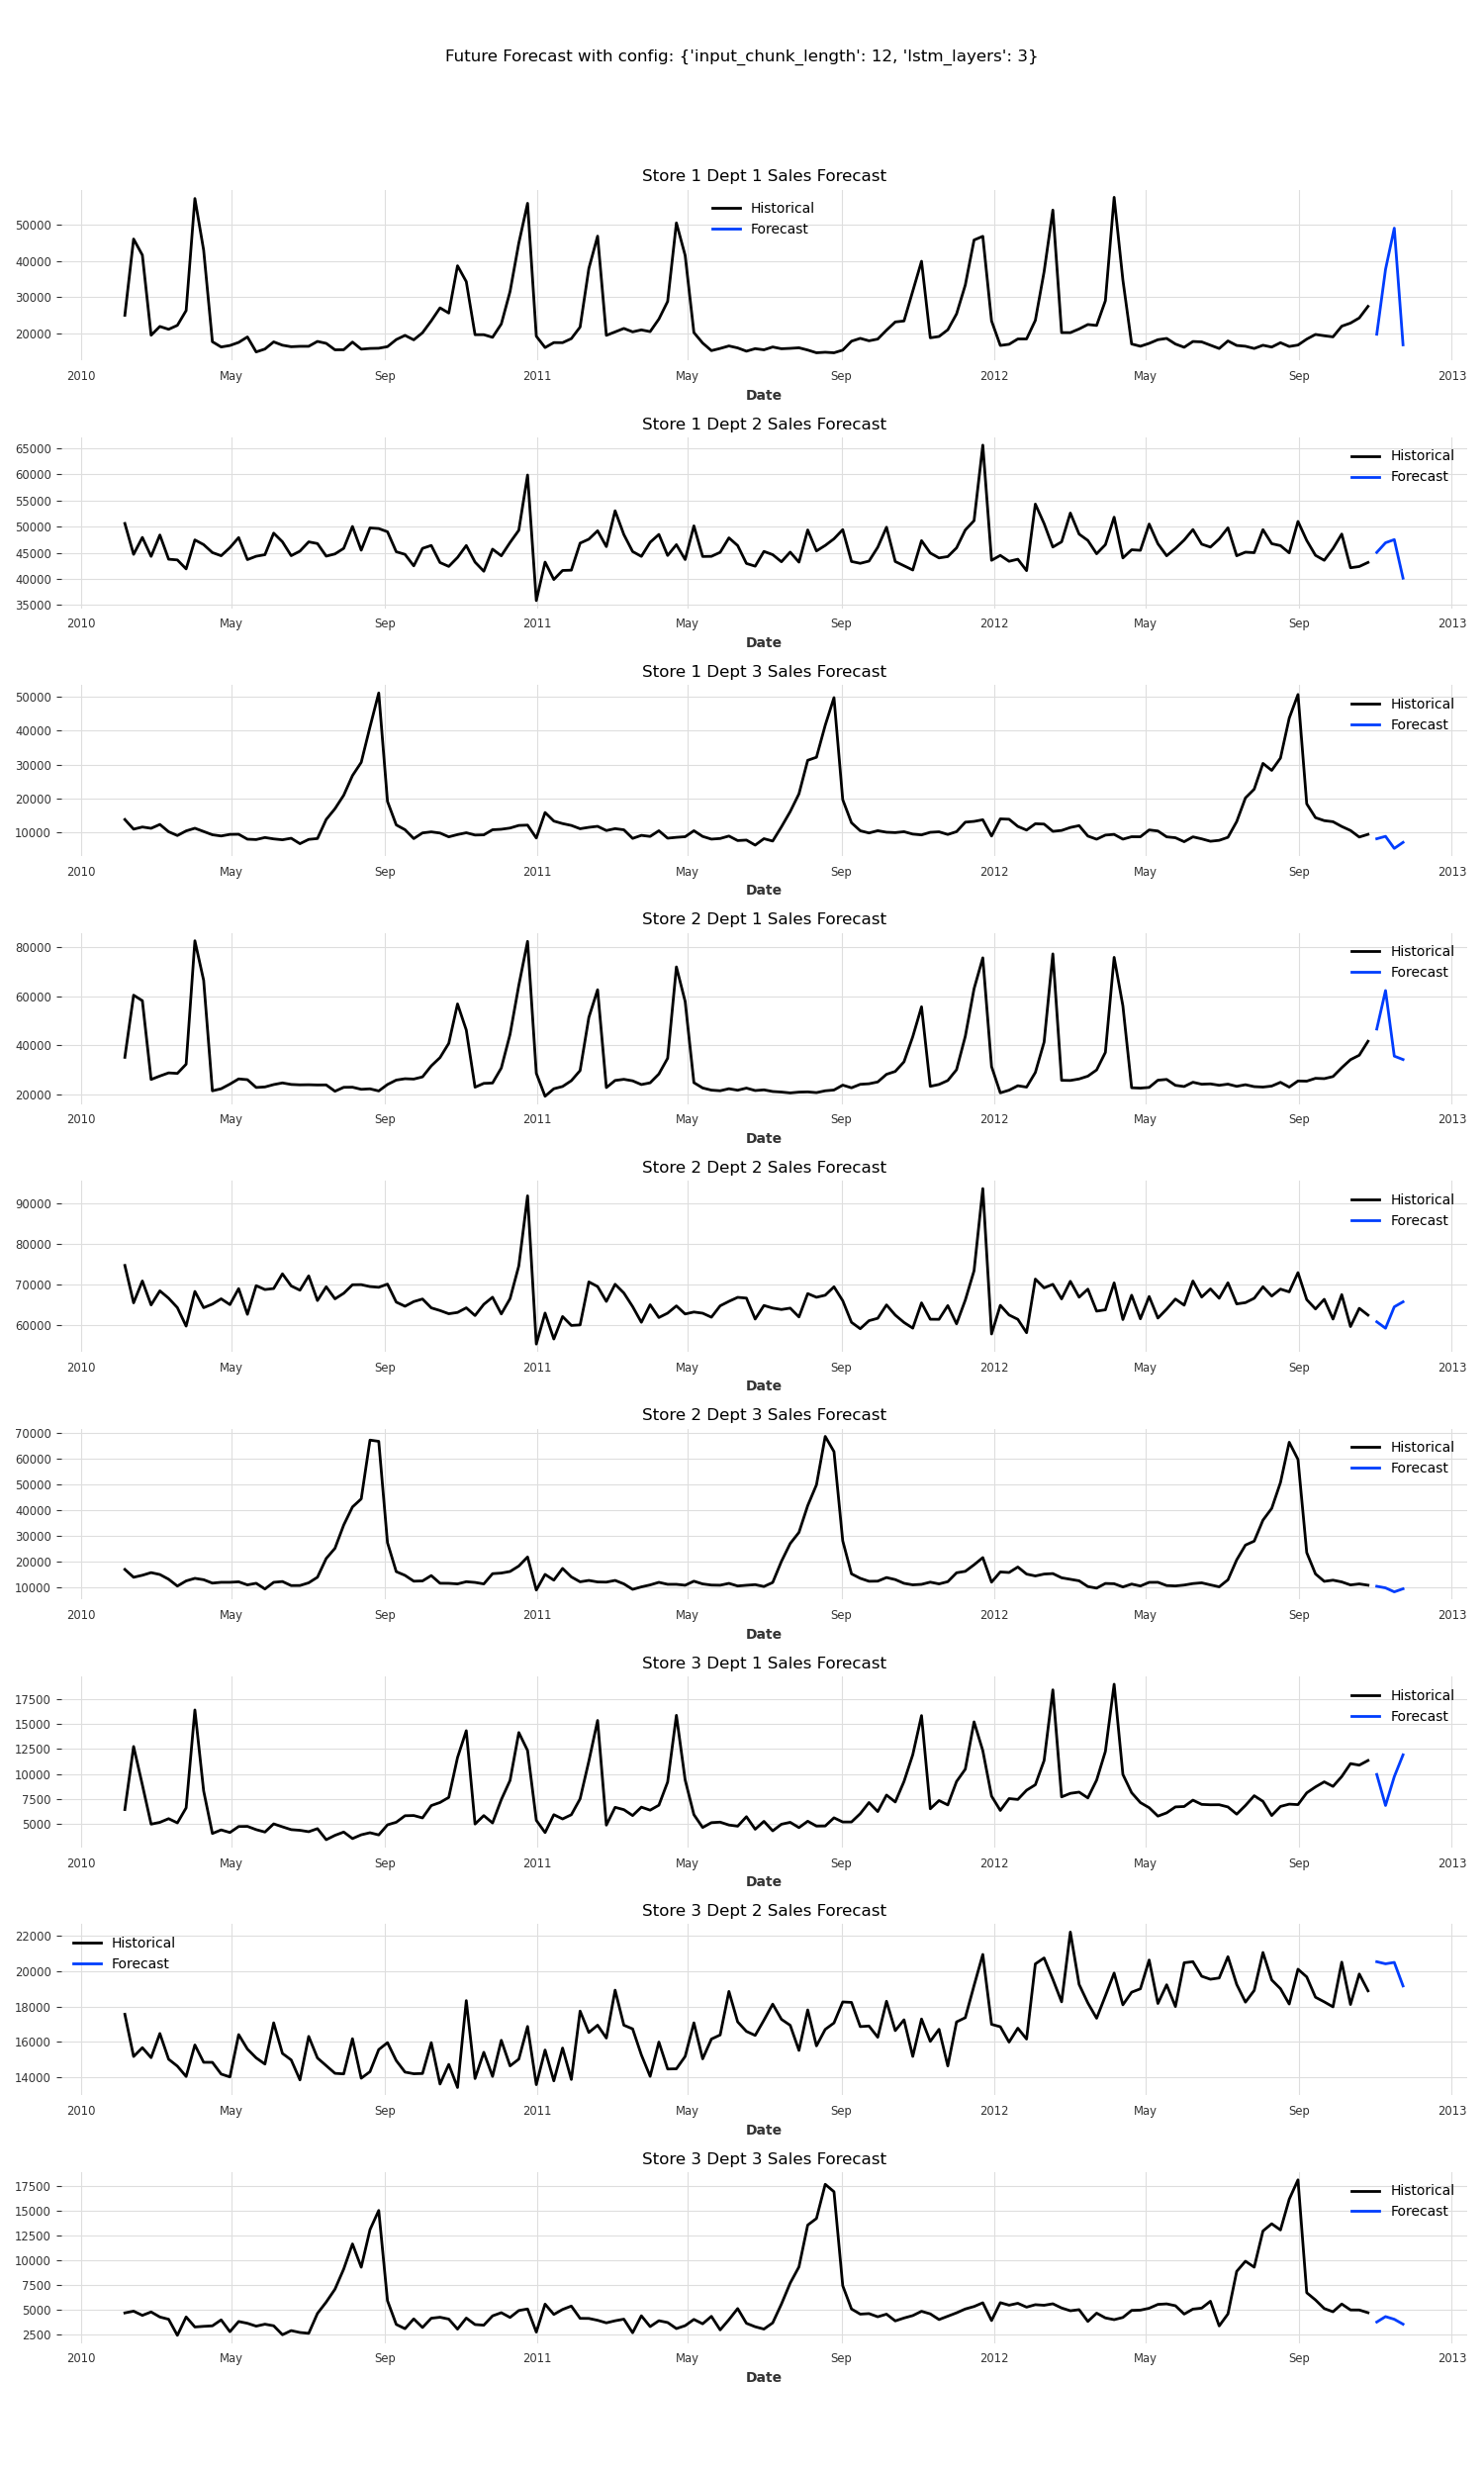

In [15]:
# Initialize preprocessing with the Walmart data
preprocessor = WalmartPreprocessor(train_df, test_df, stores_df, features_df)
    
# Create and train model with different configurations
model_configs = [
    {"input_chunk_length": 12, "lstm_layers": 2},  # Base configuration
    {"input_chunk_length": 24, "lstm_layers": 2},  # Longer history
    {"input_chunk_length": 12, "lstm_layers": 3}   # Deeper network
]
    
for config in model_configs:
    print(f"\nTraining model with configuration: {config}")
    model = WalmartModel(preprocessor, **config, n_epochs=100)
    backtest = model.train_and_validate()
        
    # Generate future forecasts
    forecast = model.forecast_future(weeks_ahead=4)

    historical = model.preprocessor.value_scaler.inverse_transform(model.preprocessor.target_series[0])
    static_vals = model.preprocessor.static_transformer.inverse_transform(model.preprocessor.target_series[0])
        
    # Plot future forecast
    fig, axs = plt.subplots(9, figsize=(15, 25), sharex=True)
    
    for i in range(9):
        store = int(static_vals[i].static_covariates["Store"]['Weekly_Sales'])
        dept = int(static_vals[i].static_covariates["Dept"]['Weekly_Sales'])
        historical[i].plot(label='Historical', ax=axs[i])
        forecast[i].plot(label='Forecast', ax=axs[i])
        axs[i].set_title(f'Store {store} Dept {dept} Sales Forecast')
        axs[i].tick_params(labelbottom=True)
    
    fig.suptitle(f'Future Forecast with config: {config}')
    plt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# TODO
- Feed isHistory for forward estimation

# Questions
- Deeper network is less good than the other 2? Why?
- Why do we have the components with the strange column names for our covariants?